In [ ]:
import os
import numpy as np
import torch
from transformers import CLIPProcessor, CLIPModel
import faiss
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the dataset path from Google Drive
base_dir = "/content/drive/MyDrive/real_final"  # Replace <folder_name> with your dataset folder name

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Loading CLIP model...")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
print("CLIP model loaded successfully!")

# Data placeholders
known_face_encodings = []
known_face_names = []

# Add known face
def add_known_face(image_path, name):
    print(f"Processing image for known face: {image_path}")
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
    embedding = outputs.cpu().numpy().flatten()
    known_face_encodings.append(embedding / np.linalg.norm(embedding))
    known_face_names.append(name)
    print(f"Added known face: {name}")

# Load known faces from 'train' folders
def load_known_faces(base_dir=base_dir):
    print("Loading known faces...")
    for class_name in os.listdir(base_dir):
        train_dir = os.path.join(base_dir, class_name, "train")
        if os.path.isdir(train_dir):
            print(f"Processing class: {class_name}")
            for image_file in os.listdir(train_dir):
                image_path = os.path.join(train_dir, image_file)
                add_known_face(image_path, class_name)
    print("All known faces loaded successfully!")

# Build FAISS index
def build_index(encodings):
    print("Building FAISS index...")
    dimension = encodings[0].shape[0]
    faiss_index = faiss.IndexFlatL2(dimension)
    faiss_index.add(np.array(encodings))
    print("FAISS index built successfully!")
    return faiss_index

# Classify with FAISS
def classify_face(face_embedding, faiss_index, known_face_names, k1=3, k2=5, threshold=0.6):
    """
    Classifies a face embedding using majority voting logic.
    Args:
        face_embedding: The embedding of the face to classify.
        faiss_index: FAISS index for known faces.
        known_face_names: List of known face names corresponding to FAISS index.
        k1: Number of nearest neighbors for majority voting.
        k2: Number of fallback neighbors.
        threshold: Similarity threshold for classification.
    Returns:
        majority_class: Predicted class label.
        class_counts: Vote counts for each class.
    """
    # Search the FAISS index for k2 nearest neighbors
    D, I = faiss_index.search(face_embedding[np.newaxis, :], k2)
    votes = {}

    # Gather votes from k1 nearest neighbors
    for idx, dist in zip(I[0][:k1], D[0][:k1]):
        if idx != -1 and dist <= threshold:
            label = known_face_names[idx]
            votes[label] = votes.get(label, 0) + 1

    # Fallback: Gather votes from k2 - k1 additional neighbors
    if not votes:
        for idx, dist in zip(I[0][k1:], D[0][k1:]):
            if idx != -1 and dist <= threshold:
                label = known_face_names[idx]
                votes[label] = votes.get(label, 0) + 1

    # Determine the majority class
    if votes:
        majority_class = max(votes, key=votes.get)
    else:
        majority_class = "Unknown"

    return majority_class, votes

# Evaluate on validation set
def evaluate(val_dir, faiss_index):
    print("Evaluating on validation set...")
    true_labels = []
    pred_labels = []
    for class_name in os.listdir(val_dir):
        val_class_dir = os.path.join(val_dir, class_name, "val")
        if os.path.isdir(val_class_dir):
            print(f"Evaluating class: {class_name}")
            for image_file in os.listdir(val_class_dir):
                image_path = os.path.join(val_class_dir, image_file)
                print(f"Evaluating image: {image_path}")
                image = Image.open(image_path).convert("RGB")
                inputs = processor(images=image, return_tensors="pt").to(device)
                with torch.no_grad():
                    outputs = model.get_image_features(**inputs)
                face_embedding = outputs.cpu().numpy().flatten()
                face_embedding /= np.linalg.norm(face_embedding)
                pred_label = classify_face(face_embedding, faiss_index)
                true_labels.append(class_name)
                pred_labels.append(pred_label)
    print("Validation completed!")
    return true_labels, pred_labels

# Metrics and Visualization
def calculate_metrics(true_labels, pred_labels):
    print("Calculating metrics...")
    print("Classification Report:")
    print(classification_report(true_labels, pred_labels))
    cm = confusion_matrix(true_labels, pred_labels, labels=list(set(true_labels)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=list(set(true_labels)), yticklabels=list(set(true_labels)))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print("Metrics calculated and visualized!")

# Main Workflow
if __name__ == "__main__":
    # Load known faces and build FAISS index
    load_known_faces()
    faiss_index = build_index(known_face_encodings)

    # Evaluate on validation set
    val_dir = os.path.join(base_dir)  # Ensure this points to the base directory
    true_labels, pred_labels = evaluate(val_dir, faiss_index)

    # Calculate metrics
    calculate_metrics(true_labels, pred_labels)


In [ ]:
!pip install transformers
!pip install faiss-cpu  # Use faiss-gpu if you have a GPU in your environment
!pip install faiss-gpu
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install pillow

# ako mi nestanu oni fajlovi, iman ih u downloadsima
import os
import numpy as np
import torch
from transformers import CLIPProcessor, CLIPModel
import faiss
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pickle
from itertools import product

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



# Set the dataset path from Google Drive
base_dir = "/content/drive/MyDrive/real_final"  # Replace with your dataset folder name

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Loading CLIP model...")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
print("CLIP model loaded successfully!")

# Data placeholders
known_face_encodings = []
known_face_names = []

# Save the known face encodings and FAISS index
def save_known_faces_and_index():
    with open('known_face_encodings (5).pkl', 'wb') as f:
        pickle.dump(known_face_encodings, f)
    with open('known_face_names (5).pkl', 'wb') as f:
        pickle.dump(known_face_names, f)
    faiss.write_index(faiss_index, 'faiss_index.index')
    print("Known faces and FAISS index saved!")

# Load the known face encodings and FAISS index
def load_known_faces_and_index():
    global known_face_encodings, known_face_names, faiss_index
    if os.path.exists('known_face_encodings (5).pkl') and os.path.exists('faiss_index.index'):
        with open('known_face_encodings (5).pkl', 'rb') as f:
            known_face_encodings = pickle.load(f)
        with open('known_face_names (5).pkl', 'rb') as f:
            known_face_names = pickle.load(f)
        faiss_index = faiss.read_index('faiss_index.index')
        print("Loaded known faces and FAISS index from disk!")
    else:
        print("No saved data found. Proceeding with processing faces...")
        load_known_faces() # This line is added to populate the lists if no saved data is found
        faiss_index = build_index(known_face_encodings)
        save_known_faces_and_index()

# Add known face
def add_known_face(image_path, name):
    print(f"Processing image for known face: {image_path}")
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
    embedding = outputs.cpu().numpy().flatten()
    known_face_encodings.append(embedding / np.linalg.norm(embedding))
    known_face_names.append(name)
    print(f"Added known face: {name}")

# Load known faces from 'train' folders
def load_known_faces(base_dir=base_dir):
    print("Loading known faces...")
    for class_name in os.listdir(base_dir):
        train_dir = os.path.join(base_dir, class_name, "train")
        if os.path.isdir(train_dir):
            print(f"Processing class: {class_name}")
            for image_file in os.listdir(train_dir):
                image_path = os.path.join(train_dir, image_file)
                add_known_face(image_path, class_name)
    print("All known faces loaded successfully!")

# Build FAISS index
def build_index(encodings):
    print("Building FAISS index...")
    dimension = encodings[0].shape[0]
    faiss_index = faiss.IndexFlatL2(dimension)
    faiss_index.add(np.array(encodings))
    print("FAISS index built successfully!")
    return faiss_index

from sklearn.metrics import accuracy_score
from itertools import product


def grid_search(val_dir, faiss_index, known_face_names, k1_values, k2_values, threshold_values, results_file="grid_search_results.txt"):
    best_params = {}
    best_accuracy = 0
    results = []  # Store detailed results

    # Write header to the results file
    with open(results_file, "w") as f:
        f.write("k1, k2, threshold, accuracy, recall, f1, tp, fp, tn, fn\n")

    print("Starting grid search...")
    for k1, k2, threshold in product(k1_values, k2_values, threshold_values):
        # Skip invalid combinations
        if (k1 == 1 and k2 == 3) or (k1 == 1 and k2 == 6 and threshold < 0.8) or (k1 == 4 and k2 == 9 and threshold < 0.95) or (k1 == 6 and k2 == 7 and threshold < 0.65):
            continue
        print(f"\nTesting parameters: k1={k1}, k2={k2}, threshold={threshold}")

        # Classification function with current parameters
        def classify_with_params(face_embedding):
            return classify_face(face_embedding, faiss_index, known_face_names, k1=k1, k2=k2, threshold=threshold)

        # Evaluate the parameters
        true_labels, pred_labels = evaluate(val_dir, faiss_index, classify_with_params)

        if not true_labels or not pred_labels:  # Debug: Check if labels are empty
            print(f"[WARNING] No labels found for k1={k1}, k2={k2}, threshold={threshold}")
            continue

        # Calculate metrics
        accuracy = accuracy_score(true_labels, pred_labels)
        recall = recall_score(true_labels, pred_labels, average="weighted", zero_division=0)
        f1 = f1_score(true_labels, pred_labels, average="weighted", zero_division=0)

        cm = confusion_matrix(true_labels, pred_labels, labels=list(set(true_labels)))
        tp = np.diag(cm).sum()
        fp = cm.sum(axis=0) - np.diag(cm)
        fn = cm.sum(axis=1) - np.diag(cm)
        tn = cm.sum() - (fp + fn + tp)

        print(f"Metrics for k1={k1}, k2={k2}, threshold={threshold}:")
        print(f"  - Accuracy: {accuracy:.4f}")
        print(f"  - Recall: {recall:.4f}")
        print(f"  - F1 Score: {f1:.4f}")
        print(f"  - TP: {tp.sum()}, FP: {fp.sum()}, TN: {tn.sum()}, FN: {fn.sum()}")

        # Append results
        results.append({
            "k1": k1,
            "k2": k2,
            "threshold": threshold,
            "accuracy": accuracy,
            "recall": recall,
            "f1": f1,
            "tp": tp.sum(),
            "fp": fp.sum(),
            "tn": tn.sum(),
            "fn": fn.sum()
        })

        # Write results to file
        with open(results_file, "a") as f:
            row = f"{k1}, {k2}, {threshold}, {accuracy:.4f}, {recall:.4f}, {f1:.4f}, {tp.sum()}, {fp.sum()}, {tn.sum()}, {fn.sum()}\n"
            print(f"Writing to file: {row.strip()}")
            f.write(row)

        # Update best parameters if accuracy is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {"k1": k1, "k2": k2, "threshold": threshold}

    print("\nGrid search completed.")
    print(f"Best parameters: {best_params}")
    print(f"Best accuracy: {best_accuracy:.4f}")

    return best_params, best_accuracy, results


# Classify with FAISS


def classify_face(face_embedding, faiss_index, known_face_names, k1=3, k2=5, threshold=0.60):
    D, I = faiss_index.search(face_embedding[np.newaxis, :], k2)
    votes = {}
    for idx, dist in zip(I[0][:k1], D[0][:k1]):
        if idx != -1 and dist <= threshold:
            label = known_face_names[idx]
            votes[label] = votes.get(label, 0) + 1
    if not votes:
        for idx, dist in zip(I[0][k1:], D[0][k1:]):
            if idx != -1 and dist <= threshold:
                label = known_face_names[idx]
                votes[label] = votes.get(label, 0) + 1
    majority_class = max(votes, key=votes.get) if votes else "Unknown"
    return majority_class, votes

# Evaluate on validation set

def evaluate(val_dir, faiss_index, classify_function):
    print("Evaluating on validation set...")
    true_labels = []
    pred_labels = []

    total_images = 0
    processed_images = 0

    for class_name in os.listdir(val_dir):
        val_class_dir = os.path.join(val_dir, class_name, "val")
        if os.path.isdir(val_class_dir):
            print(f"Processing class: {class_name}")
            for image_file in os.listdir(val_class_dir):
                total_images += 1
                image_path = os.path.join(val_class_dir, image_file)
                print(f"  - Loading image: {image_file} from class {class_name}")

                try:
                    image = Image.open(image_path).convert("RGB")
                except Exception as e:
                    print(f"    [ERROR] Failed to load image {image_file}: {e}")
                    continue

                inputs = processor(images=image, return_tensors="pt").to(device)
                with torch.no_grad():
                    outputs = model.get_image_features(**inputs)
                face_embedding = outputs.cpu().numpy().flatten()

                face_embedding /= np.linalg.norm(face_embedding)
                print(f"    - Generated face embedding for {image_file}")

                pred_label, _ = classify_function(face_embedding)
                print(f"    - Predicted label: {pred_label}")

                true_labels.append(class_name)
                pred_labels.append(pred_label)

                processed_images += 1

    print(f"\nEvaluation completed: {processed_images}/{total_images} images processed.")
    return true_labels, pred_labels

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def calculate_metrics(true_labels, pred_labels):
    print("Calculating global metrics...\n")

    unique_labels = sorted(set(true_labels + pred_labels))
    cm = confusion_matrix(true_labels, pred_labels, labels=unique_labels)

    f1 = f1_score(true_labels, pred_labels, average="weighted", zero_division=0)
    recall = recall_score(true_labels, pred_labels, average="weighted", zero_division=0)
    accuracy = accuracy_score(true_labels, pred_labels)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(true_labels, pred_labels, zero_division=0, digits=4))

    # === TP/FP/FN/TN po klasi ===
    print("\nPer-class TP, FP, FN, TN:")
    total = cm.sum()
    for i, label in enumerate(unique_labels):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = total - tp - fp - fn
        print(f"\nClass '{label}':")
        print(f"  TP = {tp}")
        print(f"  FP = {fp}")
        print(f"  FN = {fn}")
        print(f"  TN = {tn}")

    # === Vizualizacija ===
    plt.figure(figsize=(10, 8), facecolor='white')
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=unique_labels, yticklabels=unique_labels,
                square=True, cbar=False)

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig("confusion_matrix_visual.pdf", format="pdf", facecolor='white')
    plt.show()




# Main Workflow
if __name__ == "__main__":
    # Load known faces and build FAISS index if not saved
    load_known_faces_and_index()
    if not known_face_encodings:  # If there are no known faces loaded from disk
        load_known_faces()
        faiss_index = build_index(known_face_encodings)
        save_known_faces_and_index()  # Save for future use

    # Default parameters for initial evaluation
    default_k1 = 3
    default_k2 = 5
    default_threshold = 0.60

    # Evaluate on validation set with default parameters
    val_dir = os.path.join(base_dir)  # Ensure this points to the base directory
    true_labels, pred_labels = evaluate(
        val_dir,
        faiss_index,
        lambda face_embedding: classify_face(
            face_embedding, faiss_index, known_face_names, default_k1, default_k2, default_threshold
        )
    )

    # Define parameter ranges
    # DOŠLI SMO DO k1=5
    k1_values = [1]
    k2_values = [3]
    threshold_values = [0.82]

    # Run grid search
    best_params, best_accuracy, results = grid_search(
        val_dir=val_dir,
        faiss_index=faiss_index,
        known_face_names=known_face_names,
        k1_values=k1_values,
        k2_values=k2_values,
        threshold_values=threshold_values
    )


    # Output results
    print(f"Best parameters found: {best_params}")
    print(f"Best accuracy achieved: {best_accuracy}")

    # Calculate metrics
    calculate_metrics(true_labels, pred_labels)



In [19]:
# Install dependencies (run this first in a separate cell)

#!pip install transformers
#!pip install faiss-cpu
#!pip install scikit-learn
#!pip install matplotlib
#!pip install seaborn
#!pip install pillow


import time
import numpy as np
import torch
from transformers import CLIPProcessor, CLIPModel
import faiss
from PIL import Image

# --- Setup ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Primjer slike (zamijeni s vlastitom)
image_path = "/content/sample.jpg"
image = Image.open(image_path).convert("RGB")

# --- FAISS placeholder ---
# Simuliramo poznate face embeddings
dimension = 512  # CLIP ViT-B/32 embedding size
known_face_encodings = np.random.randn(10, dimension).astype("float32")  # 10 random "faces"
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(known_face_encodings)

# --- Inference timing ---
n_runs = 50
embedding_times = []
faiss_times = []

for _ in range(n_runs):
    # --- Embedding extraction ---
    start = time.time()
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
    embedding = outputs.cpu().numpy().flatten()
    embedding /= np.linalg.norm(embedding)  # Normalize
    end = time.time()
    embedding_times.append((end - start) * 1000)  # ms

    # --- FAISS search ---
    start = time.time()
    D, I = faiss_index.search(embedding[np.newaxis, :], k=5)  # top-5 neighbors
    end = time.time()
    faiss_times.append((end - start) * 1000)  # ms

# --- Results ---
print(f"Average embedding extraction time: {np.mean(embedding_times):.2f} ms")
print(f"Average FAISS search time: {np.mean(faiss_times):.2f} ms")
print(f"Total average inference (embedding + FAISS): {np.mean(embedding_times) + np.mean(faiss_times):.2f} ms")

# --- Optional: print nearest neighbor indices ---
print("Top-5 nearest neighbors indices:", I[0])
print("Distances:", D[0])



Average embedding extraction time: 40.23 ms
Average FAISS search time: 0.06 ms
Total average inference (embedding + FAISS): 40.29 ms
Top-5 nearest neighbors indices: [0 7 9 3 5]
Distances: [476.0351  495.09824 511.54987 516.50616 523.3579 ]


In [ ]:
'''
Average embedding extraction time: 56.57 ms
Average FAISS search time: 0.06 ms
Total average inference (embedding + FAISS): 56.63 ms
Top-5 nearest neighbors indices: [7 8 0 2 6]
Distances: [458.89752 464.50293 465.27136 482.47812 489.96268]
'''
'''
Average embedding extraction time: 46.72 ms
Average FAISS search time: 0.06 ms
Total average inference (embedding + FAISS): 46.78 ms
Top-5 nearest neighbors indices: [6 1 4 3 9]
Distances: [452.83252 467.61328 475.3373  487.17267 488.46652]
'''
'''
Average embedding extraction time: 39.61 ms
Average FAISS search time: 0.06 ms
Total average inference (embedding + FAISS): 39.67 ms
Top-5 nearest neighbors indices: [8 6 0 7 2]
Distances: [488.3813  508.50726 517.4967  518.72217 521.6832 ]
'''
'''
Average embedding extraction time: 71.38 ms
Average FAISS search time: 0.06 ms
Total average inference (embedding + FAISS): 71.44 ms
Top-5 nearest neighbors indices: [8 5 1 0 4]
Distances: [510.86884 514.0901  521.14966 521.4542  535.16833]
'''
'''
Average embedding extraction time: 63.11 ms
Average FAISS search time: 0.07 ms
Total average inference (embedding + FAISS): 63.18 ms
Top-5 nearest neighbors indices: [2 8 9 4 7]
Distances: [472.43073 480.3887  485.63898 493.63263 498.6315 ]
'''
'''
Average embedding extraction time: 40.14 ms
Average FAISS search time: 0.06 ms
Total average inference (embedding + FAISS): 40.21 ms
Top-5 nearest neighbors indices: [3 9 7 4 1]
Distances: [434.57822 471.1192  489.62012 493.3199  509.5108 ]
'''
'''
Average embedding extraction time: 58.47 ms
Average FAISS search time: 0.06 ms
Total average inference (embedding + FAISS): 58.53 ms
Top-5 nearest neighbors indices: [9 8 2 6 4]
Distances: [477.1498  489.8133  491.1673  497.42474 501.7336 ]
'''
'''
Average embedding extraction time: 71.70 ms
Average FAISS search time: 0.06 ms
Total average inference (embedding + FAISS): 71.76 ms
Top-5 nearest neighbors indices: [0 4 1 5 9]
Distances: [497.86438 503.38434 506.3522  508.05048 508.8994 ]
'''
'''
Average embedding extraction time: 65.29 ms
Average FAISS search time: 0.09 ms
Total average inference (embedding + FAISS): 65.38 ms
Top-5 nearest neighbors indices: [7 2 9 1 6]
Distances: [474.326   488.19495 490.8999  493.41006 502.38138]
'''
'''
Average embedding extraction time: 50.83 ms
Average FAISS search time: 0.06 ms
Total average inference (embedding + FAISS): 50.89 ms
Top-5 nearest neighbors indices: [2 4 7 9 0]
Distances: [451.73425 459.58774 481.84155 498.88556 512.90295]
'''

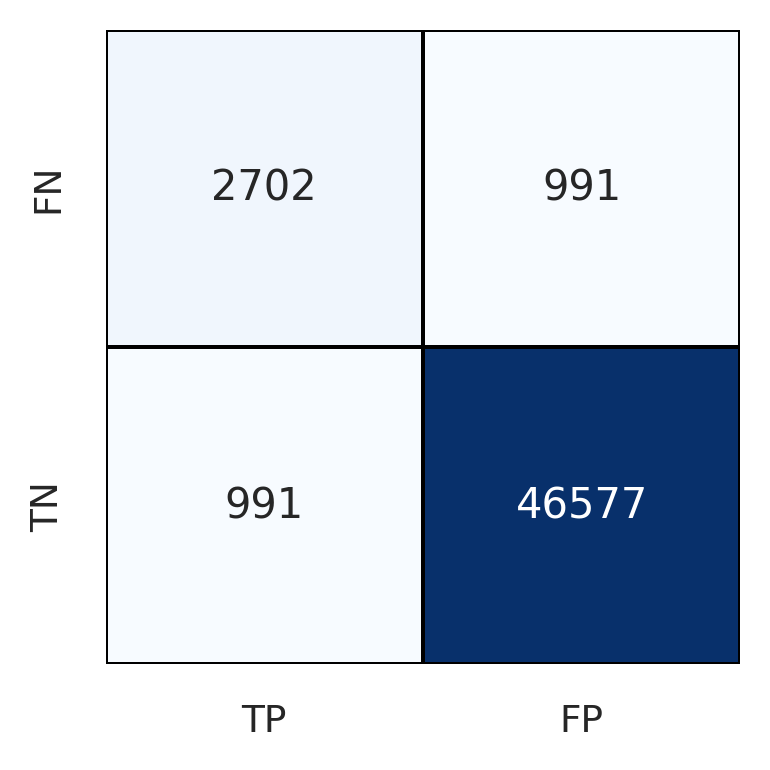

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Hardkodirane vrijednosti
TP = 2702
FP = 991
TN = 46577
FN = 991

# Confusion matrix
cm = np.array([[TP, FP],
               [FN, TN]])

plt.figure(figsize=(3.2, 2.8), dpi=300, facecolor='white')
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                 xticklabels=["TP", "FP"],
                 yticklabels=["FN", "TN"],
                 annot_kws={"size": 10},
                 linewidths=0.5, linecolor='black', square=True)

ax.tick_params(axis='both', which='major', labelsize=9)

plt.tight_layout()
# Spremi kao vektorski PDF
plt.savefig("confusion_matrix_for_paper.pdf", bbox_inches='tight', facecolor='white')
plt.show()


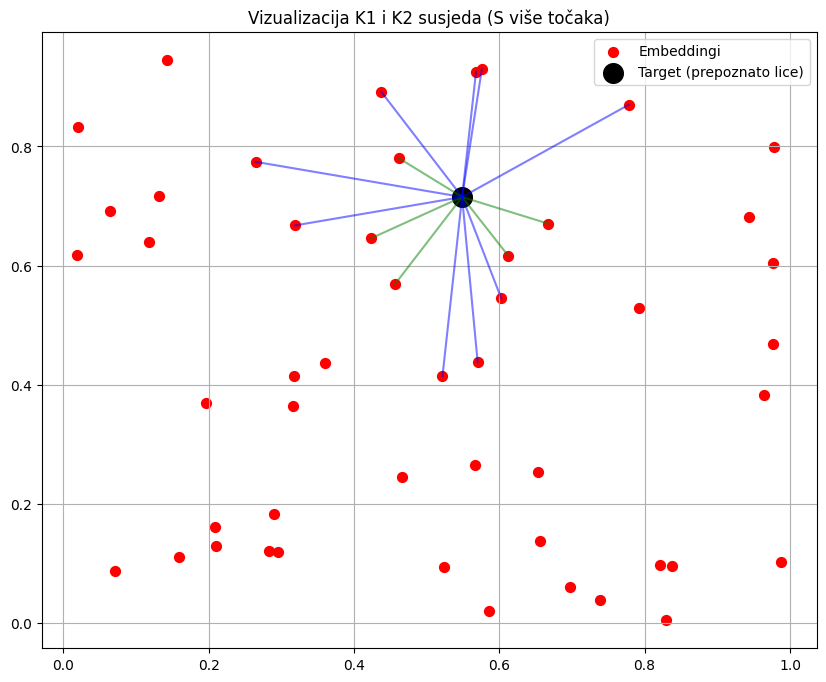

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generirajte slučajne koordinate za 50 embeddinga (npr. x, y koordinate u 2D prostoru)
np.random.seed(0)
embeddings = np.random.rand(50, 2)  # 50 embeddinga

# Odabir target embeddinga (lice koje prepoznajemo)
target = embeddings[0]

# Izračunajte udaljenost između target embeddinga i drugih (L2 udaljenost)
distances = np.linalg.norm(embeddings - target, axis=1)

# Dodajte target na početnu poziciju
plt.figure(figsize=(10, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], color='red', label='Embeddingi', s=50)

# Target embedding (prepoznato lice)
plt.scatter(target[0], target[1], color='black', label='Target (prepoznato lice)', s=200)

# K1 i K2 susjedi
k1_indices = distances.argsort()[1:6]  # K1 (5 najbližih susjeda)
k2_indices = distances.argsort()[6:15]  # K2 (10 najbližih susjeda)

# Dodajte linije između targeta i susjeda
for idx in k1_indices:
    plt.plot([target[0], embeddings[idx, 0]], [target[1], embeddings[idx, 1]], 'g-', alpha=0.5)

for idx in k2_indices:
    plt.plot([target[0], embeddings[idx, 0]], [target[1], embeddings[idx, 1]], 'b-', alpha=0.5)

# Označavanje točaka i linija
plt.legend()
plt.title("Simplified voting visualization")
plt.grid(True)
plt.show()


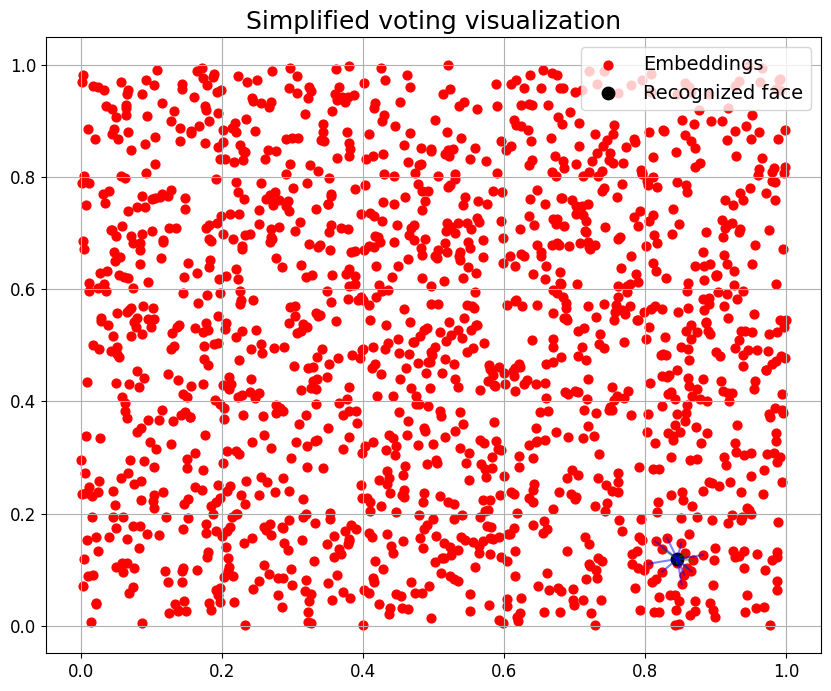

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generiraj slučajne embeddinge i target
embeddings = np.random.rand(1500, 2)
target = np.random.rand(1, 2)[0]

# Izračunaj L2 udaljenosti
distances = np.linalg.norm(embeddings - target, axis=1)

# Priprema figure
plt.figure(figsize=(10, 8))

# Scatter točke
plt.scatter(embeddings[:, 0], embeddings[:, 1], color='red', label='Embeddings', s=40)
plt.scatter(target[0], target[1], color='black', label='Recognized face', s=80)

# K1 i K2 susjedi
k1_indices = distances.argsort()[1:6]
k2_indices = distances.argsort()[6:15]

# Linije do susjeda
for idx in k1_indices:
    plt.plot([target[0], embeddings[idx, 0]], [target[1], embeddings[idx, 1]], 'g-', alpha=0.5)

for idx in k2_indices:
    plt.plot([target[0], embeddings[idx, 0]], [target[1], embeddings[idx, 1]], 'b-', alpha=0.5)

# Detalji (povećani fontovi)
plt.title("Simplified voting visualization", fontsize=18)
plt.legend(fontsize=14)
plt.tick_params(axis='both', labelsize=12)
plt.grid(True)

# Spremi kao vektorski PDF
plt.savefig("voting_visualization.pdf", format="pdf")
plt.show()


In [ ]:
!!apt-get update -qq
!apt-get install -y texlive-latex-base texlive-latex-extra texlive-fonts-recommended dvipng cm-super


import numpy as np
import matplotlib.pyplot as plt

# ✅ Use LaTeX fonts
plt.rcParams.update({
    "text.usetex": True,         # Enable LaTeX
    "font.family": "serif",      # Use serif fonts
    "font.serif": ["Computer Modern Roman"],  # Default LaTeX font
    "axes.labelsize": 15,        # Axis labels
    "axes.titlesize": 17,        # Title
    "legend.fontsize": 13,       # Legend
    "xtick.labelsize": 13,
    "ytick.labelsize": 13
})

# Generate random embeddings and target
embeddings = np.random.rand(1500, 2)
target = np.random.rand(1, 2)[0]

# Compute L2 distances
distances = np.linalg.norm(embeddings - target, axis=1)

# K1 and K2 neighbors
k1_indices = distances.argsort()[1:6]
k2_indices = distances.argsort()[6:15]

# Prepare figure
plt.figure(figsize=(10, 8))

# Scatter points
plt.scatter(embeddings[k1_indices, 0], embeddings[k1_indices, 1],
            color='green', label=r'$K_1$ neighbors (1--5)', s=50)
plt.scatter(embeddings[k2_indices, 0], embeddings[k2_indices, 1],
            color='blue', label=r'$K_2$ neighbors (6--15)', s=50)
plt.scatter(target[0], target[1], color='black',
            label=r'Recognized face (target)', s=70)

# Lines to neighbors
for idx in np.concatenate((k1_indices, k2_indices)):
    plt.plot([target[0], embeddings[idx, 0]],
             [target[1], embeddings[idx, 1]],
             color='gray', alpha=0.5)

# Dummy scatter for legend
plt.scatter([], [], color='gray', alpha=0.5, label=r'Voting connections')

# 📌 Auto zoom
all_x = np.concatenate(([target[0]], embeddings[k1_indices, 0], embeddings[k2_indices, 0]))
all_y = np.concatenate(([target[1]], embeddings[k1_indices, 1], embeddings[k2_indices, 1]))

margin = 0.1
x_min, x_max = all_x.min(), all_x.max()
y_min, y_max = all_y.min(), all_y.max()
x_range = x_max - x_min
y_range = y_max - y_min
plt.xlim(x_min - margin * x_range, x_max + margin * x_range)
plt.ylim(y_min - margin * y_range, y_max + margin * y_range)

# Labels and title (with LaTeX)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title(r"\textbf{Simplified Voting Visualization}", fontsize=16)

plt.legend(loc='upper right')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Save as vector PDF
plt.savefig("voting_visualization_final.pdf", format="pdf")
plt.show()


/tmp/ipython-input-3367343622.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(unique_labels))


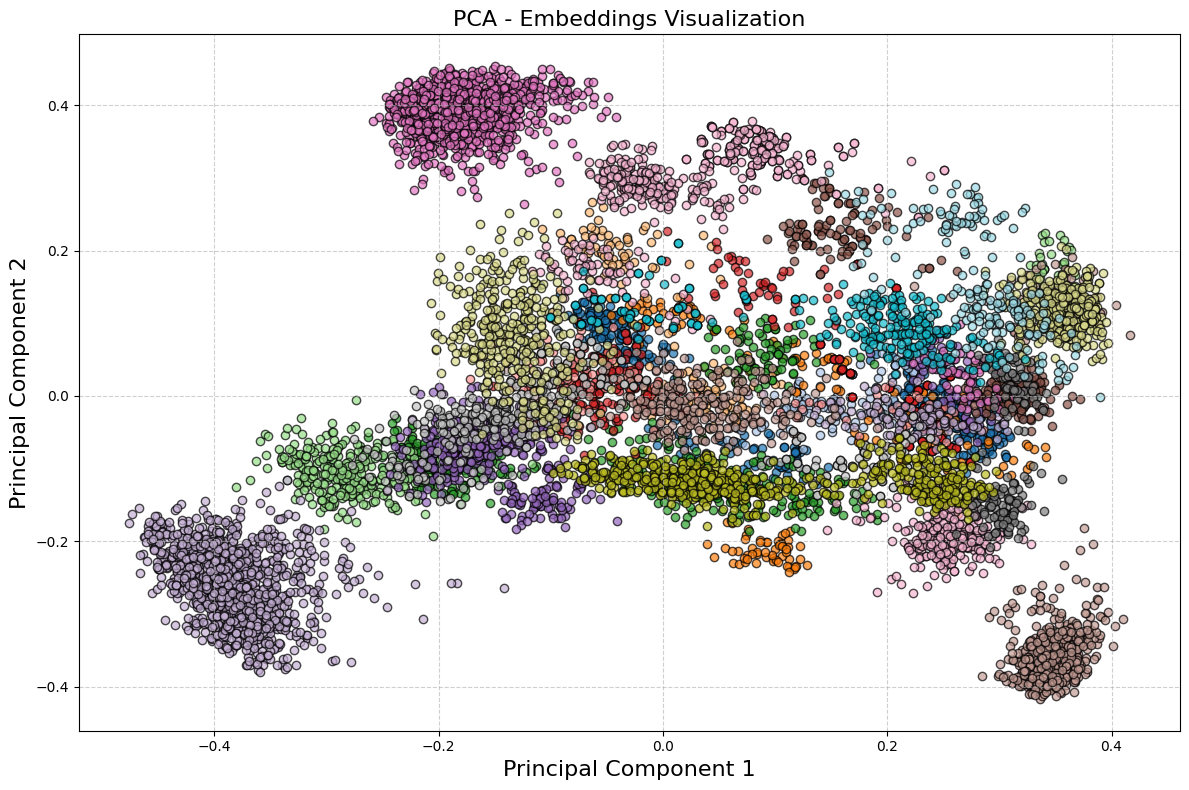

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from matplotlib import cm

# ✅ Scientific style fonts (works in Colab without real LaTeX)
plt.rcParams.update({
    "text.usetex": False,  # Use mathtext instead of external LaTeX
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# Load data
with open("known_face_encodings (5).pkl", "rb") as f:
    known_face_encodings = pickle.load(f)

with open("known_face_names (5).pkl", "rb") as f:
    known_face_names = pickle.load(f)

# Label encoding
le = LabelEncoder()
labels = le.fit_transform(known_face_names)
unique_labels = np.unique(labels)

# PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(known_face_encodings)

# Colors
colors = cm.get_cmap('tab20', len(unique_labels))

# Plot
plt.figure(figsize=(12, 8))
for i, label in enumerate(unique_labels):
    idx = labels == label
    plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1],
                color=colors(i), alpha=0.7, edgecolors="k")

# Labels + title (LaTeX-style)
plt.title(r"PCA - Embeddings Visualization", fontsize=16)
plt.xlabel(r"Principal Component 1")
plt.ylabel(r"Principal Component 2")

# Ticks
plt.tick_params(axis="both", which="major", labelsize=10)

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Save as high-quality vector PDF
plt.savefig("/content/pca_embeddings_fixed_2.pdf", format='pdf', dpi=1200)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/loading_time_vs_classes.pdf'

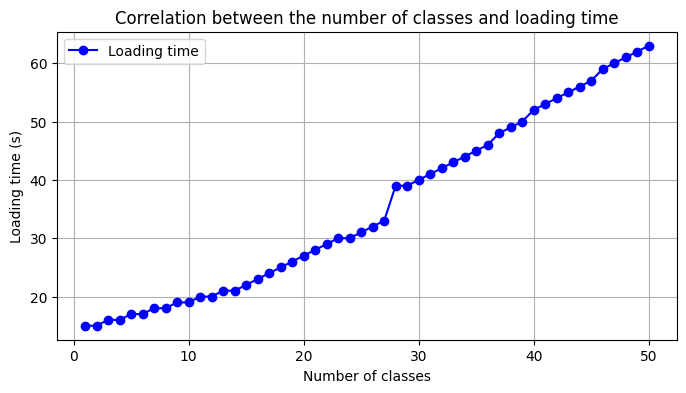

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data (approximate from the image)
num_classes = np.arange(1, 51)
loading_times = [
    15, 15, 16, 16, 17, 17, 18, 18, 19, 19,
    20, 20, 21, 21, 22, 23, 24, 25, 26, 27,
    28, 29, 30, 30, 31, 32, 33, 39, 39, 40,
    41, 42, 43, 44, 45, 46, 48, 49, 50, 52,
    53, 54, 55, 56, 57, 59, 60, 61, 62, 63
]

# Create the plot
plt.figure(figsize=(8, 4))
plt.plot(num_classes, loading_times, marker='o', color='blue', label='Loading time')
plt.title("Correlation between the number of classes and loading time")
plt.xlabel("Number of classes")
plt.ylabel("Loading time (s)")
plt.legend()
plt.grid(True)

# Save to vector PDF
output_path = "/mnt/data/loading_time_vs_classes.pdf"
plt.savefig(output_path, format='pdf')

output_path


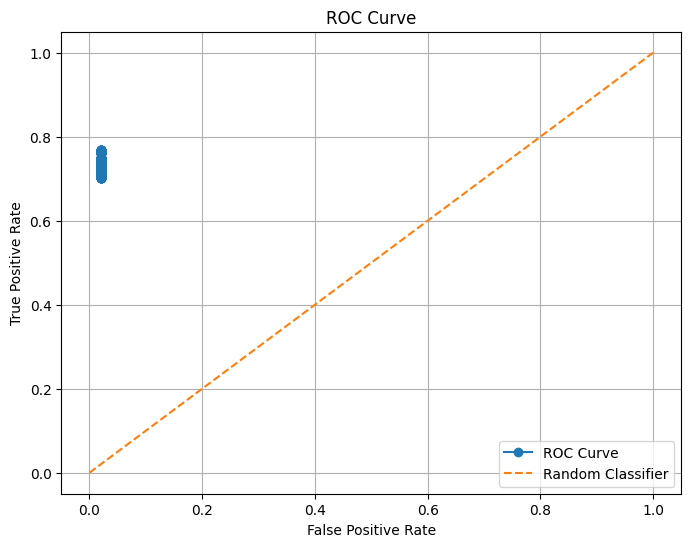

In [ ]:
#BOILERPLATE/TEMPLATE ZA ROC KRIVULJU => ŽELIMO BIT ČA BLIŽE GORNJEMU LIVEMU KUTU; ONA CRTA PO DIJAGONALI PREDSTAVLJA RANDOM 50/50 CLASSIFIER

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Podaci u formatu: k1, k2, threshold, accuracy, recall, f1, tp, fp, tn, fn
data = [
(1, 2, 1.0, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.99, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.98, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.97, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.96, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.95, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.94, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.93, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.92, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.91, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.9, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.89, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.88, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.87, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.86, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.85, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.84, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.83, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.82, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.81, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.8, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.79, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.78, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.77, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.76, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.75, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.74, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.73, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.72, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.71, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.70, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.69, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.68, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.67, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.66, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.65, 0.7305, 0.7305, 0.677, 2702, 991, 46577, 991),
(1, 2, 0.64, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 2, 0.63, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 2, 0.62, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 2, 0.61, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 2, 0.6, 0.7278, 0.7278, 0.6761, 2692, 986, 46342, 986),
(1, 2, 0.59, 0.7259, 0.7259, 0.6754, 2685, 984, 46248, 984),
(1, 2, 0.58, 0.7248, 0.7248, 0.6751, 2681, 980, 46060, 980),
(1, 2, 0.57, 0.7226, 0.7226, 0.6744, 2673, 975, 45825, 975),
(1, 3, 0.56, 0.7199, 0.7199, 0.6733, 2663, 971, 45637, 971),
(1, 2, 0.55, 0.7167, 0.7167, 0.6725, 2651, 958, 45026, 958),
(1, 2, 0.54, 0.7148, 0.7148, 0.6728, 2644, 941, 44227, 941),
(1, 2, 0.53, 0.7097, 0.7097, 0.6711, 2625, 905, 42535, 905),
(1, 2, 0.52, 0.7037, 0.7037, 0.6681, 2603, 867, 40749, 867),
(1, 2, 0.51, 0.6975, 0.6975, 0.6664, 2580, 812, 38164, 812),
(1, 2, 0.5, 0.6902, 0.6902, 0.6627, 2553, 775, 36425, 775),

(1, 3, 1.0, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.99, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.98, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.97, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.96, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.95, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.94, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.93, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.92, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.91, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.9, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.89, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.88, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.87, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.86, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.85, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.84, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.83, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.82, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.81, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.8, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.79, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.78, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.77, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.76, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.75, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.74, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.73, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.72, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.71, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.7, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.69, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.68, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.67, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.66, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.65, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.64, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.63, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.62, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.61, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 3, 0.6, 0.7278, 0.7278, 0.6761, 2692, 986, 46342, 986),
(1, 3, 0.59, 0.7259, 0.7259, 0.6754, 2685, 984, 46248, 984),
(1, 3, 0.58, 0.7248, 0.7248, 0.6751, 2681, 980, 46060, 980),
(1, 3, 0.57, 0.7226, 0.7226, 0.6744, 2673, 975, 45825, 975),
(1, 3, 0.56, 0.7199, 0.7199, 0.6733, 2663, 971, 45637, 971),
(1, 3, 0.55, 0.7167, 0.7167, 0.6725, 2651, 958, 45026, 958),
(1, 3, 0.54, 0.7148, 0.7148, 0.6728, 2644, 941, 44227, 941),
(1, 3, 0.53, 0.7097, 0.7097, 0.6711, 2625, 905, 42535, 905),
(1, 3, 0.52, 0.7037, 0.7037, 0.6681, 2603, 867, 40749, 867),
(1, 3, 0.51, 0.6975, 0.6975, 0.6664, 2580, 812, 38164, 812),
(1, 3, 0.5, 0.6902, 0.6902, 0.6627, 2553, 775, 36425, 775),

(1, 4, 1.0, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.99, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.98, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.97, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.96, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.95, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.94, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.93, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.92, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.91, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.9, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.89, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.88, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.87, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.86, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.85, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.84, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.83, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.82, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.81, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.8, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.79, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.78, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.77, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.76, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.75, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.74, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.73, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.72, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.71, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.7, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.69, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.68, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.67, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.66, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.65, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.64, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.63, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.62, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.61, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 4, 0.6, 0.7278, 0.7278, 0.6761, 2692, 986, 46342, 986),
(1, 4, 0.59, 0.7259, 0.7259, 0.6754, 2685, 984, 46248, 984),
(1, 4, 0.58, 0.7248, 0.7248, 0.6751, 2681, 980, 46060, 980),
(1, 4, 0.57, 0.7226, 0.7226, 0.6744, 2673, 975, 45825, 975),
(1, 4, 0.56, 0.7199, 0.7199, 0.6733, 2663, 971, 45637, 971),
(1, 4, 0.55, 0.7167, 0.7167, 0.6725, 2651, 958, 45026, 958),
(1, 4, 0.54, 0.7148, 0.7148, 0.6728, 2644, 941, 44227, 941),
(1, 4, 0.53, 0.7097, 0.7097, 0.6711, 2625, 905, 42535, 905),
(1, 4, 0.54, 0.7148, 0.7148, 0.6728, 2644, 941, 44227, 941),
(1, 4, 0.52, 0.7037, 0.7037, 0.6681, 2603, 867, 40749, 867),
(1, 4, 0.51, 0.6975, 0.6975, 0.6664, 2580, 812, 38164, 812),
(1, 4, 0.5, 0.6902, 0.6902, 0.6627, 2553, 775, 36425, 775),

(1, 5, 1.0, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.99, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.98, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.97, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.96, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.95, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.94, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.93, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.92, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.91, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.9, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.89, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.88, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.87, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.86, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.85, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.84, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.83, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.82, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.81, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.8, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.79, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.78, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.77, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.76, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.75, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.74, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.73, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.72, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.71, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.7, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.69, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.68, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.67, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.66, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.65, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.64, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.63, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.62, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.61, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 5, 0.6, 0.7278, 0.7278, 0.6761, 2692, 986, 46342, 986),
(1, 5, 0.59, 0.7259, 0.7259, 0.6754, 2685, 984, 46248, 984),
(1, 5, 0.58, 0.7248, 0.7248, 0.6751, 2681, 980, 46060, 980),
(1, 5, 0.57, 0.7226, 0.7226, 0.6744, 2673, 975, 45825, 975),
(1, 5, 0.56, 0.7199, 0.7199, 0.6733, 2663, 971, 45637, 971),
(1, 5, 0.55, 0.7167, 0.7167, 0.6725, 2651, 958, 45026, 958),
(1, 5, 0.54, 0.7148, 0.7148, 0.6728, 2644, 941, 44227, 941),
(1, 5, 0.53, 0.7097, 0.7097, 0.6711, 2625, 905, 42535, 905),
(1, 5, 0.52, 0.7037, 0.7037, 0.6681, 2603, 867, 40749, 867),
(1, 5, 0.51, 0.6975, 0.6975, 0.6664, 2580, 812, 38164, 812),
(1, 5, 0.5, 0.6902, 0.6902, 0.6627, 2553, 775, 36425, 775),

(1, 6, 1.0, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.99, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.98, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.97, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.96, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.95, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.94, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.93, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.92, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.91, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.9, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.89, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.88, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.87, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.86, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.85, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.84, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.83, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.82, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.81, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.8, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.79, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.78, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.77, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.76, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.75, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.74, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.73, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.72, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.71, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.7, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.69, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.68, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.67, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.66, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.65, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.64, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.63, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.62, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.61, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 6, 0.6, 0.7278, 0.7278, 0.6761, 2692, 986, 46342, 986),
(1, 6, 0.59, 0.7259, 0.7259, 0.6754, 2685, 984, 46248, 984),
(1, 6, 0.58, 0.7248, 0.7248, 0.6751, 2681, 980, 46060, 980),
(1, 6, 0.57, 0.7226, 0.7226, 0.6744, 2673, 975, 45825, 975),
(1, 6, 0.56, 0.7199, 0.7199, 0.6733, 2663, 971, 45637, 971),
(1, 6, 0.55, 0.7167, 0.7167, 0.6725, 2651, 958, 45026, 958),
(1, 6, 0.54, 0.7148, 0.7148, 0.6728, 2644, 941, 44227, 941),
(1, 6, 0.53, 0.7097, 0.7097, 0.6711, 2625, 905, 42535, 905),
(1, 6, 0.52, 0.7037, 0.7037, 0.6681, 2603, 867, 40749, 867),
(1, 6, 0.51, 0.6975, 0.6975, 0.6664, 2580, 812, 38164, 812),
(1, 6, 0.5, 0.6902, 0.6902, 0.6627, 2553, 775, 36425, 775),

(1, 7, 1.0, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.99, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.98, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.97, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.96, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.95, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.94, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.93, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.92, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.91, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.9, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.89, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.88, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.87, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.86, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.85, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.84, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.83, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.82, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.81, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.8, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.79, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.78, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.77, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.76, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.75, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.74, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.73, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.72, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.71, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.7, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.69, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.68, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.67, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.66, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.65, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.64, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.63, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.62, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.61, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 7, 0.6, 0.7278, 0.7278, 0.6761, 2692, 986, 46342, 986),
(1, 7, 0.59, 0.7259, 0.7259, 0.6754, 2685, 984, 46248, 984),
(1, 7, 0.58, 0.7248, 0.7248, 0.6751, 2681, 980, 46060, 980),
(1, 7, 0.57, 0.7226, 0.7226, 0.6744, 2673, 975, 45825, 975),
(1, 7, 0.56, 0.7199, 0.7199, 0.6733, 2663, 971, 45637, 971),
(1, 7, 0.55, 0.7167, 0.7167, 0.6725, 2651, 958, 45026, 958),
(1, 7, 0.54, 0.7148, 0.7148, 0.6728, 2644, 941, 44227, 941),
(1, 7, 0.53, 0.7097, 0.7097, 0.6711, 2625, 905, 42535, 905),
(1, 7, 0.52, 0.7037, 0.7037, 0.6681, 2603, 867, 40749, 867),
(1, 7, 0.51, 0.6975, 0.6975, 0.6664, 2580, 812, 38164, 812),
(1, 7, 0.5, 0.6902, 0.6902, 0.6627, 2553, 775, 36425, 775),


(1, 8, 1.0, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.99, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.98, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.97, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.96, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.95, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.94, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.93, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.92, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.91, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.9, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.89, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.88, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.87, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.86, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.85, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.84, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.83, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.82, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.81, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.8, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.79, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.78, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.77, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.76, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.75, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.74, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.73, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.72, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.71, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.7, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.69, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.68, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.67, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.66, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.65, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.64, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.63, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.62, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.61, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 8, 0.6, 0.7278, 0.7278, 0.6761, 2692, 986, 46342, 986),
(1, 8, 0.59, 0.7259, 0.7259, 0.6754, 2685, 984, 46248, 984),
(1, 8, 0.58, 0.7248, 0.7248, 0.6751, 2681, 980, 46060, 980),
(1, 8, 0.57, 0.7226, 0.7226, 0.6744, 2673, 975, 45825, 975),
(1, 8, 0.56, 0.7199, 0.7199, 0.6733, 2663, 971, 45637, 971),
(1, 8, 0.55, 0.7167, 0.7167, 0.6725, 2651, 958, 45026, 958),
(1, 8, 0.54, 0.7148, 0.7148, 0.6728, 2644, 941, 44227, 941),
(1, 8, 0.53, 0.7097, 0.7097, 0.6711, 2625, 905, 42535, 905),
(1, 8, 0.52, 0.7037, 0.7037, 0.6681, 2603, 867, 40749, 867),
(1, 8, 0.51, 0.6975, 0.6975, 0.6664, 2580, 812, 38164, 812),
(1, 8, 0.5, 0.6902, 0.6902, 0.6627, 2553, 775, 36425, 775),

(1, 9, 1.0, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.99, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.98, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.97, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.96, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.95, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.94, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.93, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.92, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.91, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.9, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.89, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.88, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.87, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.86, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.85, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.84, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.83, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.82, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.81, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.8, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.79, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.78, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.77, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.76, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.75, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.74, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.73, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.72, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.71, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.7, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.69, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.68, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.67, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.66, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.65, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.64, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.63, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.62, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.61, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 9, 0.6, 0.7278, 0.7278, 0.6761, 2692, 986, 46342, 986),
(1, 9, 0.59, 0.7259, 0.7259, 0.6754, 2685, 984, 46248, 984),
(1, 9, 0.58, 0.7248, 0.7248, 0.6751, 2681, 980, 46060, 980),
(1, 9, 0.57, 0.7226, 0.7226, 0.6744, 2673, 975, 45825, 975),
(1, 9, 0.56, 0.7199, 0.7199, 0.6733, 2663, 971, 45637, 971),
(1, 9, 0.55, 0.7167, 0.7167, 0.6725, 2651, 958, 45026, 958),
(1, 9, 0.54, 0.7148, 0.7148, 0.6728, 2644, 941, 44227, 941),
(1, 9, 0.53, 0.7097, 0.7097, 0.6711, 2625, 905, 42535, 905),
(1, 9, 0.52, 0.7037, 0.7037, 0.6681, 2603, 867, 40749, 867),
(1, 9, 0.51, 0.6975, 0.6975, 0.6664, 2580, 812, 38164, 812),
(1, 9, 0.5, 0.6902, 0.6902, 0.6627, 2553, 775, 36425, 775),

(1, 10, 1.0, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.99, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.98, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.97, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.96, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.95, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.94, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.93, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.92, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.91, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.9, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.89, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.88, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.87, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.86, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.85, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.84, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.83, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.82, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.81, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.8, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.79, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.78, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.77, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.76, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.75, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.74, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.73, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.72, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.71, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.7, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.69, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.68, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.67, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.66, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.65, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.64, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.63, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.62, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.61, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(1, 10, 0.6, 0.7278, 0.7278, 0.6761, 2692, 986, 46342, 986),
(1, 10, 0.59, 0.7259, 0.7259, 0.6754, 2685, 984, 46248, 984),
(1, 10, 0.58, 0.7248, 0.7248, 0.6751, 2681, 980, 46060, 980),
(1, 10, 0.57, 0.7226, 0.7226, 0.6744, 2673, 975, 45825, 975),
(1, 10, 0.56, 0.7199, 0.7199, 0.6733, 2663, 971, 45637, 971),
(1, 10, 0.55, 0.7167, 0.7167, 0.6725, 2651, 958, 45026, 958),
(1, 10, 0.54, 0.7148, 0.7148, 0.6728, 2644, 941, 44227, 941),
(1, 10, 0.53, 0.7097, 0.7097, 0.6711, 2625, 905, 42535, 905),
(1, 10, 0.52, 0.7037, 0.7037, 0.6681, 2603, 867, 40749, 867),
(1, 10, 0.51, 0.6975, 0.6975, 0.6664, 2580, 812, 38164, 812),
(1, 10, 0.5, 0.6902, 0.6902, 0.6627, 2553, 775, 36425, 775),

(2, 3, 1.0, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.99, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.98, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.97, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.96, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.95, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.94, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.93, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.92, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.91, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.89, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.88, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.87, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.86, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.85, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.84, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.83, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.82, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.81, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.8, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.79, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.78, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.77, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.76, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.75, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.74, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.73, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.72, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.71, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.7, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.69, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.68, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.67, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.66, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.65, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.64, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.63, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 3, 0.62, 0.7299, 0.7299, 0.6770, 2700, 989, 46483, 989),
(2, 3, 0.61, 0.7291, 0.7291, 0.6767, 2697, 987, 46389, 987),
(2, 3, 0.6, 0.7278, 0.7278, 0.6761, 2692, 986, 46342, 986),
(2, 3, 0.59, 0.7259, 0.7259, 0.6754, 2685, 984, 46248, 984),
(2, 3, 0.58, 0.7248, 0.7248, 0.6751, 2681, 980, 46060, 980),
(2, 3, 0.57, 0.7226, 0.7226, 0.6744, 2673, 975, 45825, 975),
(2, 3, 0.56, 0.7199, 0.7199, 0.6733, 2663, 971, 45637, 971),
(2, 3, 0.55, 0.7167, 0.7167, 0.6725, 2651, 958, 45026, 958),
(2, 3, 0.54, 0.7148, 0.7148, 0.6728, 2644, 941, 44227, 941),
(2, 3, 0.53, 0.7097, 0.7097, 0.6711, 2625, 905, 42535, 905),
(2, 3, 0.52, 0.7037, 0.7037, 0.6681, 2603, 867, 40749, 867),
(2, 3, 0.51, 0.6975, 0.6975, 0.6664, 2580, 812, 38164, 812),
(2, 3, 0.5, 0.6902, 0.6902, 0.6627, 2553, 775, 36425, 775),


(2, 4, 1.0, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.99, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.98, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.97, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.96, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.95, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.94, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.93, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.92, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.91, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.9, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.89, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.88, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.87, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.86, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.85, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.84, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.83, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.82, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.81, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.8, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.79, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.78, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.77, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.76, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.75, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.74, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.73, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.72, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.71, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.7, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.69, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.68, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.67, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.66, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.65, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.64, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.63, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 4, 0.62, 0.7299, 0.7299, 0.6770, 2700, 989, 46483, 989),
(2, 4, 0.61, 0.7291, 0.7291, 0.6767, 2697, 987, 46389, 987),
(2, 4, 0.6, 0.7278, 0.7278, 0.6761, 2692, 986, 46342, 986),
(2, 4, 0.59, 0.7259, 0.7259, 0.6754, 2685, 984, 46248, 984),
(2, 4, 0.58, 0.7248, 0.7248, 0.6751, 2681, 980, 46060, 980),
(2, 4, 0.57, 0.7226, 0.7226, 0.6744, 2673, 975, 45825, 975),
(2, 4, 0.56, 0.7199, 0.7199, 0.6733, 2663, 971, 45637, 971),
(2, 4, 0.55, 0.7167, 0.7167, 0.6725, 2651, 958, 45026, 958),
(2, 4, 0.54, 0.7148, 0.7148, 0.6728, 2644, 941, 44227, 941),
(2, 3, 0.53, 0.7097, 0.7097, 0.6711, 2625, 905, 42535, 905),
(2, 4, 0.52, 0.7037, 0.7037, 0.6681, 2603, 867, 40749, 867),
(2, 4, 0.51, 0.6975, 0.6975, 0.6664, 2580, 812, 38164, 812),
(2, 4, 0.5, 0.6902, 0.6902, 0.6627, 2553, 775, 36425, 775),



(2, 5, 1.0, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.99, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.98, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.97, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.96, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.95, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.94, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.93, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.92, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.91, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.9, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.89, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.88, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.87, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.86, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.85, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.84, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.83, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.82, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.81, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.8, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.79, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.78, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.77, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.76, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.75, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.74, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.73, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.72, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.71, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.7, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.69, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.68, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.67, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.66, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.65, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.64, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.63, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 5, 0.62, 0.7299, 0.7299, 0.6770, 2700, 989, 46483, 989),
(2, 5, 0.61, 0.7291, 0.7291, 0.6767, 2697, 987, 46389, 987),
(2, 5, 0.6, 0.7278, 0.7278, 0.6761, 2692, 986, 46342, 986),
(2, 5, 0.59, 0.7259, 0.7259, 0.6754, 2685, 984, 46248, 984),
(2, 5, 0.58, 0.7248, 0.7248, 0.6751, 2681, 980, 46060, 980),
(2, 5, 0.57, 0.7226, 0.7226, 0.6744, 2673, 975, 45825, 975),
(2, 5, 0.56, 0.7199, 0.7199, 0.6733, 2663, 971, 45637, 971),
(2, 5, 0.55, 0.7167, 0.7167, 0.6725, 2651, 958, 45026, 958),
(2, 5, 0.54, 0.7148, 0.7148, 0.6728, 2644, 941, 44227, 941),
(2, 5, 0.53, 0.7097, 0.7097, 0.6711, 2625, 905, 42535, 905),
(2, 5, 0.52, 0.7037, 0.7037, 0.6681, 2603, 867, 40749, 867),
(2, 5, 0.51, 0.6975, 0.6975, 0.6664, 2580, 812, 38164, 812),
(2, 5, 0.5, 0.6902, 0.6902, 0.6627, 2553, 775, 36425, 775),



(2, 6, 1.0, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.99, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.98, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.97, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.96, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.95, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.94, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.93, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.92, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.91, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.9, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.89, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.88, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.87, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.86, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.85, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.84, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.83, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.82, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.81, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.8, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.79, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.78, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.77, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.76, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.75, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.74, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.73, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.72, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.71, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.7, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.69, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.68, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.67, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.66, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.65, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.64, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.63, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 6, 0.62, 0.7299, 0.7299, 0.6770, 2700, 989, 46483, 989),
(2, 6, 0.61, 0.7291, 0.7291, 0.6767, 2697, 987, 46389, 987),
(2, 6, 0.6, 0.7278, 0.7278, 0.6761, 2692, 986, 46342, 986),
(2, 6, 0.59, 0.7259, 0.7259, 0.6754, 2685, 984, 46248, 984),
(2, 6, 0.58, 0.7248, 0.7248, 0.6751, 2681, 980, 46060, 980),
(2, 6, 0.57, 0.7226, 0.7226, 0.6744, 2673, 975, 45825, 975),
(2, 6, 0.56, 0.7199, 0.7199, 0.6733, 2663, 971, 45637, 971),
(2, 6, 0.55, 0.7167, 0.7167, 0.6725, 2651, 958, 45026, 958),
(2, 6, 0.54, 0.7148, 0.7148, 0.6728, 2644, 941, 44227, 941),
(2, 6, 0.53, 0.7097, 0.7097, 0.6711, 2625, 905, 42535, 905),
(2, 6, 0.52, 0.7037, 0.7037, 0.6681, 2603, 867, 40749, 867),
(2, 6, 0.51, 0.6975, 0.6975, 0.6664, 2580, 812, 38164, 812),
(2, 6, 0.5, 0.6902, 0.6902, 0.6627, 2553, 775, 36425, 775),

(2, 7, 1.0, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.99, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.98, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.97, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.96, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.95, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.94, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.93, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.92, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.91, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.9, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.89, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.88, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.87, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.86, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.85, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.84, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.83, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.82, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.81, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.8, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.79, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.78, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.77, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.76, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.75, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.74, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.73, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.72, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.71, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.7, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.69, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.68, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.67, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.66, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.65, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.64, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.63, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 7, 0.62, 0.7299, 0.7299, 0.6770, 2700, 989, 46483, 989),
(2, 7, 0.61, 0.7291, 0.7291, 0.6767, 2697, 987, 46389, 987),
(2, 7, 0.6, 0.7278, 0.7278, 0.6761, 2692, 986, 46342, 986),
(2, 7, 0.59, 0.7259, 0.7259, 0.6754, 2685, 984, 46248, 984),
(2, 7, 0.58, 0.7248, 0.7248, 0.6751, 2681, 980, 46060, 980),
(2, 7, 0.57, 0.7226, 0.7226, 0.6744, 2673, 975, 45825, 975),
(2, 7, 0.56, 0.7199, 0.7199, 0.6733, 2663, 971, 45637, 971),
(2, 7, 0.55, 0.7167, 0.7167, 0.6725, 2651, 958, 45026, 958),
(2, 7, 0.54, 0.7148, 0.7148, 0.6728, 2644, 941, 44227, 941),
(2, 7, 0.53, 0.7097, 0.7097, 0.6711, 2625, 905, 42535, 905),
(2, 7, 0.52, 0.7037, 0.7037, 0.6681, 2603, 867, 40749, 867),
(2, 7, 0.51, 0.6975, 0.6975, 0.6664, 2580, 812, 38164, 812),
(2, 7, 0.5, 0.6902, 0.6902, 0.6627, 2553, 775, 36425, 775),

(2, 8, 1.0, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.99, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.98, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.97, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.96, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.95, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.94, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.93, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.92, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.91, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.9, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.89, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.88, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.87, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.86, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.85, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.84, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.83, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.82, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.81, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.8, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.79, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.78, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.77, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.76, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.75, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.74, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.73, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.72, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.71, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.7, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.69, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.68, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.67, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.66, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.65, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.64, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.63, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 8, 0.62, 0.7299, 0.7299, 0.6770, 2700, 989, 46483, 989),
(2, 8, 0.61, 0.7291, 0.7291, 0.6767, 2697, 987, 46389, 987),
(2, 8, 0.6, 0.7278, 0.7278, 0.6761, 2692, 986, 46342, 986),
(2, 8, 0.59, 0.7259, 0.7259, 0.6754, 2685, 984, 46248, 984),
(2, 8, 0.58, 0.7248, 0.7248, 0.6751, 2681, 980, 46060, 980),
(2, 8, 0.57, 0.7226, 0.7226, 0.6744, 2673, 975, 45825, 975),
(2, 8, 0.56, 0.7199, 0.7199, 0.6733, 2663, 971, 45637, 971),
(2, 8, 0.55, 0.7167, 0.7167, 0.6725, 2651, 958, 45026, 958),
(2, 8, 0.54, 0.7148, 0.7148, 0.6728, 2644, 941, 44227, 941),
(2, 8, 0.53, 0.7097, 0.7097, 0.6711, 2625, 905, 42535, 905),
(2, 8, 0.52, 0.7037, 0.7037, 0.6681, 2603, 867, 40749, 867),
(2, 8, 0.51, 0.6975, 0.6975, 0.6664, 2580, 812, 38164, 812),
(2, 8, 0.5, 0.6902, 0.6902, 0.6627, 2553, 775, 36425, 775),

(2, 9, 1.0, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.99, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.98, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.97, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.96, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.95, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.94, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.93, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.92, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.91, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.9, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.89, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.88, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.87, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.86, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.85, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.84, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.83, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.82, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.81, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.8, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.79, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.78, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.77, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.76, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.75, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.74, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.73, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.72, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.71, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.7, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.69, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.68, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.67, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.66, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.65, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.64, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.63, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 9, 0.62, 0.7299, 0.7299, 0.6770, 2700, 989, 46483, 989),
(2, 9, 0.61, 0.7291, 0.7291, 0.6767, 2697, 987, 46389, 987),
(2, 9, 0.6, 0.7278, 0.7278, 0.6761, 2692, 986, 46342, 986),
(2, 9, 0.59, 0.7259, 0.7259, 0.6754, 2685, 984, 46248, 984),
(2, 9, 0.58, 0.7248, 0.7248, 0.6751, 2681, 980, 46060, 980),
(2, 9, 0.57, 0.7226, 0.7226, 0.6744, 2673, 975, 45825, 975),
(2, 9, 0.56, 0.7199, 0.7199, 0.6733, 2663, 971, 45637, 971),
(2, 9, 0.55, 0.7167, 0.7167, 0.6725, 2651, 958, 45026, 958),
(2, 9, 0.54, 0.7148, 0.7148, 0.6728, 2644, 941, 44227, 941),
(2, 9, 0.53, 0.7097, 0.7097, 0.6711, 2625, 905, 42535, 905),
(2, 9, 0.52, 0.7037, 0.7037, 0.6681, 2603, 867, 40749, 867),
(2, 9, 0.51, 0.6975, 0.6975, 0.6664, 2580, 812, 38164, 812),
(2, 9, 0.5, 0.6902, 0.6902, 0.6627, 2553, 775, 36425, 775),


(2, 10, 1.0, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.99, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.98, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.97, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.96, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.95, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.94, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.93, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.92, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.91, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.9, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.89, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.88, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.87, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.86, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.85, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.84, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.83, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.82, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.81, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.8, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.79, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.78, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.77, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.76, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.75, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.74, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.73, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.72, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.71, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.7, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.69, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.68, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.67, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.66, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.65, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.64, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.63, 0.7305, 0.7305, 0.6770, 2702, 991, 46577, 991),
(2, 10, 0.62, 0.7299, 0.7299, 0.6770, 2700, 989, 46483, 989),
(2, 10, 0.61, 0.7291, 0.7291, 0.6767, 2697, 987, 46389, 987),
(2, 10, 0.6, 0.7278, 0.7278, 0.6761, 2692, 986, 46342, 986),
(2, 10, 0.59, 0.7259, 0.7259, 0.6754, 2685, 984, 46248, 984),
(2, 10, 0.58, 0.7248, 0.7248, 0.6751, 2681, 980, 46060, 980),
(2, 10, 0.57, 0.7226, 0.7226, 0.6744, 2673, 975, 45825, 975),
(2, 10, 0.56, 0.7199, 0.7199, 0.6733, 2663, 971, 45637, 971),
(2, 10, 0.55, 0.7167, 0.7167, 0.6725, 2651, 958, 45026, 958),
(2, 10, 0.54, 0.7148, 0.7148, 0.6728, 2644, 941, 44227, 941),
(2, 10, 0.53, 0.7097, 0.7097, 0.6711, 2625, 905, 42535, 905),
(2, 10, 0.52, 0.7037, 0.7037, 0.6681, 2603, 867, 40749, 867),
(2, 10, 0.51, 0.6975, 0.6975, 0.6664, 2580, 812, 38164, 812),
(2, 10, 0.5, 0.6902, 0.6902, 0.6627, 2553, 775, 36425, 775),

(3, 4, 1.0, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.99, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.98, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.97, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.96, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.95, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.94, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.93, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.92, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.91, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.9, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 4, 0.89, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.88, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.87, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.86, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.85, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.84, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.83, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.82, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.81, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.8, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.79, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.78, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.77, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.76, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.75, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.74, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.73, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.72, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.71, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.7, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 4, 0.69, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 4, 0.68, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 4, 0.67, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 4, 0.66, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 4, 0.65, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 4, 0.64, 0.7164, 0.7164, 0.6640, 2650, 1045, 49115, 1045),
(3, 4, 0.63, 0.7172, 0.7172, 0.6646, 2653, 1042, 48974, 1042),
(3, 4, 0.62, 0.7178, 0.7178, 0.6656, 2655, 1036, 48692, 1036),
(3, 4, 0.61, 0.7180, 0.7180, 0.6662, 2656, 1030, 48410, 1030),
(3, 4, 0.6, 0.7188, 0.7188, 0.6674, 2659, 1021, 47987, 1021),
(3, 4, 0.59, 0.7175, 0.7175, 0.6669, 2654, 1017, 47799, 1017),
(3, 4, 0.58, 0.7183, 0.7183, 0.6682, 2657, 1006, 47282, 1006),
(3, 4, 0.57, 0.7178, 0.7178, 0.6689, 2655, 995, 46765, 995),
(3, 4, 0.56, 0.7170, 0.7170, 0.6696, 2652, 984, 46248, 984),
(3, 4, 0.55, 0.7148, 0.7148, 0.6699, 2644, 967, 45449, 967),
(3, 4, 0.54, 0.7140, 0.7140, 0.6717, 2641, 946, 44462, 946),
(3, 4, 0.53, 0.7099, 0.7099, 0.6712, 2626, 906, 42582, 906),
(3, 4, 0.52, 0.7040, 0.7040, 0.6682, 2604, 868, 40796, 868),
(3, 4, 0.51, 0.6980, 0.6980, 0.6669, 2582, 812, 38164, 812),
(3, 4, 0.5, 0.6905, 0.6905, 0.6627, 2554, 776, 36472, 776),

(3, 5, 1.0, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.99, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.98, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.97, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.96, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.95, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.94, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.93, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.92, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.91, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.9, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 5, 0.89, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.88, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.87, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.86, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.85, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.84, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.83, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.82, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.81, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.8, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.79, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.78, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.77, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.76, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.75, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.74, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.73, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.72, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.71, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.7, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 5, 0.69, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 5, 0.68, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 5, 0.67, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 5, 0.66, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 5, 0.65, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 5, 0.64, 0.7164, 0.7164, 0.6640, 2650, 1045, 49115, 1045),
(3, 5, 0.63, 0.7172, 0.7172, 0.6646, 2653, 1042, 48974, 1042),
(3, 5, 0.62, 0.7178, 0.7178, 0.6656, 2655, 1036, 48692, 1036),
(3, 5, 0.61, 0.7180, 0.7180, 0.6662, 2656, 1030, 48410, 1030),
(3, 5, 0.6, 0.7188, 0.7188, 0.6674, 2659, 1021, 47987, 1021),
(3, 5, 0.59, 0.7175, 0.7175, 0.6669, 2654, 1017, 47799, 1017),
(3, 5, 0.58, 0.7183, 0.7183, 0.6682, 2657, 1006, 47282, 1006),
(3, 5, 0.57, 0.7178, 0.7178, 0.6689, 2655, 995, 46765, 995),
(3, 5, 0.56, 0.7170, 0.7170, 0.6696, 2652, 984, 46248, 984),
(3, 5, 0.55, 0.7148, 0.7148, 0.6699, 2644, 967, 45449, 967),
(3, 5, 0.54, 0.7140, 0.7140, 0.6717, 2641, 946, 44462, 946),
(3, 5, 0.53, 0.7099, 0.7099, 0.6712, 2626, 906, 42582, 906),
(3, 5, 0.52, 0.7040, 0.7040, 0.6682, 2604, 868, 40796, 868),
(3, 5, 0.51, 0.6980, 0.6980, 0.6669, 2582, 812, 38164, 812),
(3, 5, 0.5, 0.6905, 0.6905, 0.6627, 2554, 776, 36472, 776),



(3, 6, 1.0, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.99, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.98, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.97, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.96, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.95, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.94, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.93, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.92, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.91, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.9, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 6, 0.89, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.88, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.87, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.86, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.85, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.84, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.83, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.82, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.81, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.8, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.79, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.78, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.77, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.76, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.75, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.74, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.73, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.72, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.71, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.7, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 6, 0.69, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 6, 0.68, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 6, 0.67, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 6, 0.66, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 6, 0.65, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 6, 0.64, 0.7164, 0.7164, 0.6640, 2650, 1045, 49115, 1045),
(3, 6, 0.63, 0.7172, 0.7172, 0.6646, 2653, 1042, 48974, 1042),
(3, 6, 0.62, 0.7178, 0.7178, 0.6656, 2655, 1036, 48692, 1036),
(3, 6, 0.61, 0.7180, 0.7180, 0.6662, 2656, 1030, 48410, 1030),
(3, 6, 0.6, 0.7188, 0.7188, 0.6674, 2659, 1021, 47987, 1021),
(3, 6, 0.59, 0.7175, 0.7175, 0.6669, 2654, 1017, 47799, 1017),
(3, 6, 0.58, 0.7183, 0.7183, 0.6682, 2657, 1006, 47282, 1006),
(3, 6, 0.57, 0.7178, 0.7178, 0.6689, 2655, 995, 46765, 995),
(3, 6, 0.56, 0.7170, 0.7170, 0.6696, 2652, 984, 46248, 984),
(3, 6, 0.55, 0.7148, 0.7148, 0.6699, 2644, 967, 45449, 967),
(3, 6, 0.54, 0.7140, 0.7140, 0.6717, 2641, 946, 44462, 946),
(3, 6, 0.53, 0.7099, 0.7099, 0.6712, 2626, 906, 42582, 906),
(3, 6, 0.52, 0.7040, 0.7040, 0.6682, 2604, 868, 40796, 868),
(3, 6, 0.51, 0.6980, 0.6980, 0.6669, 2582, 812, 38164, 812),
(3, 6, 0.5, 0.6905, 0.6905, 0.6627, 2554, 776, 36472, 776),


(3, 7, 1.0, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.99, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.98, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.97, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.96, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.95, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.94, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.93, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.92, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.91, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.9, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 7, 0.89, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.88, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.87, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.86, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.85, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.84, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.83, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.82, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.81, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.8, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.79, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.78, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.77, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.76, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.75, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.74, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.73, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.72, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.71, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.7, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 7, 0.69, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 7, 0.68, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 7, 0.67, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 7, 0.66, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 7, 0.65, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 7, 0.64, 0.7164, 0.7164, 0.6640, 2650, 1045, 49115, 1045),
(3, 7, 0.63, 0.7172, 0.7172, 0.6646, 2653, 1042, 48974, 1042),
(3, 7, 0.62, 0.7178, 0.7178, 0.6656, 2655, 1036, 48692, 1036),
(3, 7, 0.61, 0.7180, 0.7180, 0.6662, 2656, 1030, 48410, 1030),
(3, 7, 0.6, 0.7188, 0.7188, 0.6674, 2659, 1021, 47987, 1021),
(3, 7, 0.59, 0.7175, 0.7175, 0.6669, 2654, 1017, 47799, 1017),
(3, 7, 0.58, 0.7183, 0.7183, 0.6682, 2657, 1006, 47282, 1006),
(3, 7, 0.57, 0.7178, 0.7178, 0.6689, 2655, 995, 46765, 995),
(3, 7, 0.56, 0.7170, 0.7170, 0.6696, 2652, 984, 46248, 984),
(3, 7, 0.55, 0.7148, 0.7148, 0.6699, 2644, 967, 45449, 967),
(3, 7, 0.54, 0.7140, 0.7140, 0.6717, 2641, 946, 44462, 946),
(3, 7, 0.53, 0.7099, 0.7099, 0.6712, 2626, 906, 42582, 906),
(3, 7, 0.52, 0.7040, 0.7040, 0.6682, 2604, 868, 40796, 868),
(3, 7, 0.51, 0.6980, 0.6980, 0.6669, 2582, 812, 38164, 812),
(3, 7, 0.5, 0.6905, 0.6905, 0.6627, 2554, 776, 36472, 776),



(3, 8, 1.0, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.99, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.98, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.98, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.97, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.96, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.95, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.94, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.93, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.92, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.91, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.9, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.89, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.88, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.87, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.86, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.85, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.84, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.83, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.82, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.81, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.8, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.79, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.78, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.77, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.76, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.75, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.74, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.73, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.72, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.71, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.7, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 8, 0.69, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 8, 0.68, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 8, 0.67, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 8, 0.66, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 8, 0.65, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 8, 0.64, 0.7164, 0.7164, 0.6640, 2650, 1045, 49115, 1045),
(3, 8, 0.63, 0.7172, 0.7172, 0.6646, 2653, 1042, 48974, 1042),
(3, 8, 0.62, 0.7178, 0.7178, 0.6656, 2655, 1036, 48692, 1036),
(3, 8, 0.61, 0.7180, 0.7180, 0.6662, 2656, 1030, 48410, 1030),
(3, 8, 0.6, 0.7188, 0.7188, 0.6674, 2659, 1021, 47987, 1021),
(3, 8, 0.59, 0.7175, 0.7175, 0.6669, 2654, 1017, 47799, 1017),
(3, 8, 0.58, 0.7183, 0.7183, 0.6682, 2657, 1006, 47282, 1006),
(3, 8, 0.57, 0.7178, 0.7178, 0.6689, 2655, 995, 46765, 995),
(3, 8, 0.56, 0.7170, 0.7170, 0.6696, 2652, 984, 46248, 984),
(3, 8, 0.55, 0.7148, 0.7148, 0.6699, 2644, 967, 45449, 967),
(3, 8, 0.54, 0.7140, 0.7140, 0.6717, 2641, 946, 44462, 946),
(3, 8, 0.53, 0.7099, 0.7099, 0.6712, 2626, 906, 42582, 906),
(3, 8, 0.52, 0.7040, 0.7040, 0.6682, 2604, 868, 40796, 868),
(3, 8, 0.51, 0.6980, 0.6980, 0.6669, 2582, 812, 38164, 812),
(3, 8, 0.5, 0.6905, 0.6905, 0.6627, 2554, 776, 36472, 776),


(3, 9, 1.0, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.99, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.98, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.97, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.96, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.95, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.94, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.93, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.92, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.91, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.9, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.89, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.88, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.87, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.86, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.85, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.84, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.83, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.82, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.81, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.8, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.79, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.78, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.77, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.76, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.75, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.74, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.73, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.72, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.71, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.7, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 9, 0.69, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 9, 0.68, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 9, 0.67, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 9, 0.66, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 9, 0.65, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 9, 0.64, 0.7164, 0.7164, 0.6640, 2650, 1045, 49115, 1045),
(3, 9, 0.63, 0.7172, 0.7172, 0.6646, 2653, 1042, 48974, 1042),
(3, 9, 0.62, 0.7178, 0.7178, 0.6656, 2655, 1036, 48692, 1036),
(3, 9, 0.61, 0.7180, 0.7180, 0.6662, 2656, 1030, 48410, 1030),
(3, 9, 0.6, 0.7188, 0.7188, 0.6674, 2659, 1021, 47987, 1021),
(3, 9, 0.59, 0.7175, 0.7175, 0.6669, 2654, 1017, 47799, 1017),
(3, 9, 0.58, 0.7183, 0.7183, 0.6682, 2657, 1006, 47282, 1006),
(3, 9, 0.57, 0.7178, 0.7178, 0.6689, 2655, 995, 46765, 995),
(3, 9, 0.56, 0.7170, 0.7170, 0.6696, 2652, 984, 46248, 984),
(3, 9, 0.55, 0.7148, 0.7148, 0.6699, 2644, 967, 45449, 967),
(3, 9, 0.54, 0.7140, 0.7140, 0.6717, 2641, 946, 44462, 946),
(3, 9, 0.53, 0.7099, 0.7099, 0.6712, 2626, 906, 42582, 906),
(3, 9, 0.52, 0.7040, 0.7040, 0.6682, 2604, 868, 40796, 868),
(3, 9, 0.51, 0.6980, 0.6980, 0.6669, 2582, 812, 38164, 812),
(3, 9, 0.5, 0.6905, 0.6905, 0.6627, 2554, 776, 36472, 776),

(3, 10, 1.0, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.99, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.98, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.97, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.96, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.95, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.94, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.93, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.92, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.91, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.9, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.89, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.88, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.87, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.86, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.85, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.84, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.83, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.82, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.81, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.8, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.79, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.78, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.77, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.76, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.75, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.74, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.73, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.72, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.71, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.7, 0.7159, 0.7159, 0.6635, 2648, 1047, 49209, 1047),
(3, 10, 0.69, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 10, 0.68, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 10, 0.67, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 10, 0.66, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 10, 0.65, 0.7161, 0.7161, 0.6637, 2649, 1046, 49162, 1046),
(3, 10, 0.64, 0.7164, 0.7164, 0.6640, 2650, 1045, 49115, 1045),
(3, 10, 0.63, 0.7172, 0.7172, 0.6646, 2653, 1042, 48974, 1042),
(3, 10, 0.62, 0.7178, 0.7178, 0.6656, 2655, 1036, 48692, 1036),
(3, 10, 0.61, 0.7180, 0.7180, 0.6662, 2656, 1030, 48410, 1030),
(3, 10, 0.6, 0.7188, 0.7188, 0.6674, 2659, 1021, 47987, 1021),
(3, 10, 0.59, 0.7175, 0.7175, 0.6669, 2654, 1017, 47799, 1017),
(3, 10, 0.58, 0.7183, 0.7183, 0.6682, 2657, 1006, 47282, 1006),
(3, 10, 0.57, 0.7178, 0.7178, 0.6689, 2655, 995, 46765, 995),
(3, 10, 0.56, 0.7170, 0.7170, 0.6696, 2652, 984, 46248, 984),
(3, 10, 0.55, 0.7148, 0.7148, 0.6699, 2644, 967, 45449, 967),
(3, 10, 0.54, 0.7140, 0.7140, 0.6717, 2641, 946, 44462, 946),
(3, 10, 0.53, 0.7099, 0.7099, 0.6712, 2626, 906, 42582, 906),
(3, 10, 0.52, 0.7040, 0.7040, 0.6682, 2604, 868, 40796, 868),
(3, 10, 0.51, 0.6980, 0.6980, 0.6669, 2582, 812, 38164, 812),
(3, 10, 0.5, 0.6905, 0.6905, 0.6627, 2554, 776, 36472, 776),


(4, 5, 1.0, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 5, 0.95, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 5, 0.9, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 5, 0.85, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 5, 0.8, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 5, 0.75, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 5, 0.7, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 5, 0.68, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 5, 0.67, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 5, 0.66, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 5, 0.65, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 5, 0.6, 0.7172, 0.7172, 0.6644, 2653, 1025, 48175, 1025),
(4, 5, 0.55, 0.7129, 0.7129, 0.6672, 2637, 972, 45684, 972),
(4, 5, 0.5, 0.6894, 0.6894, 0.6611, 2550, 778, 36566, 778),
(4, 6, 1.0, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 6, 0.95, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 6, 0.9, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 6, 0.85, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 6, 0.8, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 6, 0.75, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 6, 0.7, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 6, 0.68, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 6, 0.67, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 6, 0.66, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 6, 0.65, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 6, 0.6, 0.7172, 0.7172, 0.6644, 2653, 1025, 48175, 1025),
(4, 6, 0.55, 0.7129, 0.7129, 0.6672, 2637, 972, 45684, 972),
(4, 6, 0.5, 0.6894, 0.6894, 0.6611, 2550, 778, 36566, 778),
(4, 7, 1.0, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 7, 0.95, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 7, 0.9, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 7, 0.85, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 7, 0.8, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 7, 0.75, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 7, 0.7, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 7, 0.68, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 7, 0.67, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 7, 0.66, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 7, 0.65, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 7, 0.6, 0.7172, 0.7172, 0.6644, 2653, 1025, 48175, 1025),
(4, 7, 0.55, 0.7129, 0.7129, 0.6672, 2637, 972, 45684, 972),
(4, 7, 0.5, 0.6894, 0.6894, 0.6611, 2550, 778, 36566, 778),
(4, 8, 1.0, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 8, 0.95, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 8, 0.9, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 8, 0.85, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 8, 0.8, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 8, 0.75, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 8, 0.7, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 8, 0.68, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 8, 0.67, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 8, 0.66, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 8, 0.65, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 8, 0.6, 0.7172, 0.7172, 0.6644, 2653, 1025, 48175, 1025),
(4, 8, 0.55, 0.7129, 0.7129, 0.6672, 2637, 972, 45684, 972),
(4, 8, 0.5, 0.6894, 0.6894, 0.6611, 2550, 778, 36566, 778),
(4, 9, 1.0, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 9, 0.95, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 9, 0.9, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 9, 0.85, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 9, 0.8, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 9, 0.75, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 8, 0.7, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 9, 0.68, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 9, 0.67, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 9, 0.66, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 9, 0.65, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 9, 0.6, 0.7172, 0.7172, 0.6644, 2653, 1025, 48175, 1025),
(4, 9, 0.55, 0.7129, 0.7129, 0.6672, 2637, 972, 45684, 972),
(4, 9, 0.5, 0.6894, 0.6894, 0.6611, 2550, 778, 36566, 778),
(4, 10, 1.0, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 10, 0.95, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 10, 0.9, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 10, 0.85, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 10, 0.8, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 10, 0.75, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 10, 0.7, 0.7151, 0.7151, 0.6613, 2645, 1048, 49256, 1048),
(4, 10, 0.68, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 10, 0.67, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 10, 0.66, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 10, 0.65, 0.7153, 0.7153, 0.6615, 2646, 1047, 49209, 1047),
(4, 10, 0.6, 0.7172, 0.7172, 0.6644, 2653, 1025, 48175, 1025),
(4, 10, 0.55, 0.7129, 0.7129, 0.6672, 2637, 972, 45684, 972),
(4, 10, 0.5, 0.6894, 0.6894, 0.6611, 2550, 778, 36566, 778),

(5, 6, 1.0, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 6, 0.95, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 6, 0.9, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 6, 0.85, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 6, 0.8, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 6, 0.75, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 6, 0.7, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 6, 0.68, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 6, 0.67, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 6, 0.66, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 6, 0.65, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 6, 0.6, 0.7118, 0.7118, 0.6591, 2633, 1047, 49209, 1047),
(5, 6, 0.55, 0.7121, 0.7121, 0.6660, 2634, 977, 45919, 977),
(5, 6, 0.5, 0.6910, 0.6910, 0.6632, 2556, 774, 36378, 774),
(5, 7, 1.0, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 7, 0.95, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 7, 0.9, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 7, 0.85, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 7, 0.8, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 7, 0.75, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 7, 0.7, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 7, 0.68, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 7, 0.67, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 7, 0.66, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 7, 0.65, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 7, 0.6, 0.7118, 0.7118, 0.6591, 2633, 1047, 49209, 1047),
(5, 7, 0.55, 0.7121, 0.7121, 0.6660, 2634, 977, 45919, 977),
(5, 7, 0.5, 0.6910, 0.6910, 0.6632, 2556, 774, 36378, 774),
(5, 8, 1.0, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 8, 0.95, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 8, 0.9, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 8, 0.85, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 8, 0.8, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 8, 0.75, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 8, 0.7, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 8, 0.68, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 8, 0.67, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 8, 0.66, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 8, 0.65, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 8, 0.6, 0.7118, 0.7118, 0.6591, 2633, 1047, 49209, 1047),
(5, 8, 0.55, 0.7121, 0.7121, 0.6660, 2634, 977, 45919, 977),
(5, 8, 0.5, 0.6910, 0.6910, 0.6632, 2556, 774, 36378, 774),
(5, 9, 1.0, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 9, 0.95, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 9, 0.9, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 9, 0.85, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 9, 0.8, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 9, 0.75, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 9, 0.68, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 9, 0.7, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 9, 0.68, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 9, 0.67, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 9, 0.66, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 9, 0.65, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 9, 0.6, 0.7118, 0.7118, 0.6591, 2633, 1047, 49209, 1047),
(5, 9, 0.55, 0.7121, 0.7121, 0.6660, 2634, 977, 45919, 977),
(5, 9, 0.5, 0.6910, 0.6910, 0.6632, 2556, 774, 36378, 774),
(5, 10, 1.0, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 10, 0.95, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 10, 0.9, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 10, 0.85, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 10, 0.8, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 10, 0.75, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 10, 0.7, 0.7078, 0.7078, 0.6542, 2618, 1077, 50619, 1077),
(5, 10, 0.68, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 10, 0.67, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 10, 0.66, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 10, 0.65, 0.7083, 0.7083, 0.6548, 2620, 1075, 50525, 1075),
(5, 10, 0.6, 0.7118, 0.7118, 0.6591, 2633, 1047, 49209, 1047),
(5, 10, 0.55, 0.7121, 0.7121, 0.6660, 2634, 977, 45919, 977),
(5, 10, 0.5, 0.6910, 0.6910, 0.6632, 2556, 774, 36378, 774),

(6, 7, 1.0, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 7, 0.95, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 7, 0.9, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 7, 0.85, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 7, 0.8, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 7, 0.75, 0.7105, 0.7105, 0.6558, 2628, 1067, 50149, 1067),
(6, 7, 0.7, 0.7105, 0.7105, 0.6558, 2628, 1067, 50149, 1067),
(6, 7, 0.68, 0.7105, 0.7105, 0.6558, 2628, 1067, 50149, 1067),
(6, 7, 0.67, 0.7105, 0.7105, 0.6558, 2628, 1067, 50149, 1067),
(6, 7, 0.66, 0.7105, 0.7105, 0.6558, 2628, 1067, 50149, 1067),
(6, 7, 0.65, 0.7105, 0.7105, 0.6558, 2628, 1067, 50149, 1067),
(6, 7, 0.6, 0.7132, 0.7132, 0.6594, 2638, 1042, 48974, 1042),
(6, 7, 0.55, 0.7124, 0.7124, 0.6656, 2635, 976, 45872, 976),
(6, 7, 0.5, 0.6915, 0.6915, 0.6631, 2558, 772, 36284, 772),

(6, 8, 1.0, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 8, 0.95, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 8, 0.9, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 8, 0.85, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 8, 0.8, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 8, 0.75, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 8, 0.68, 0.7105, 0.7105, 0.6558, 2628, 1067, 50149, 1067),
(6, 8, 0.67, 0.7105, 0.7105, 0.6558, 2628, 1067, 50149, 1067),
(6, 8, 0.66, 0.7105, 0.7105, 0.6558, 2628, 1067, 50149, 1067),
(6, 8, 0.65, 0.7105, 0.7105, 0.6558, 2628, 1067, 50149, 1067),
(6, 8, 0.6, 0.7132, 0.7132, 0.6594, 2638, 1042, 48974, 1042),
(6, 8, 0.55, 0.7124, 0.7124, 0.6656, 2635, 976, 45872, 976),
(6, 8, 0.5, 0.6915, 0.6915, 0.6631, 2558, 772, 36284, 772),

(6, 9, 1.0, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 9, 0.95, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 9, 0.9, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 9, 0.85, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 9, 0.8, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 9, 0.75, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 9, 0.7, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 9, 0.68, 0.7105, 0.7105, 0.6558, 2628, 1067, 50149, 1067),
(6, 9, 0.67, 0.7105, 0.7105, 0.6558, 2628, 1067, 50149, 1067),
(6, 9, 0.66, 0.7105, 0.7105, 0.6558, 2628, 1067, 50149, 1067),
(6, 9, 0.65, 0.7105, 0.7105, 0.6558, 2628, 1067, 50149, 1067),
(6, 9, 0.6, 0.7132, 0.7132, 0.6594, 2638, 1042, 48974, 1042),
(6, 9, 0.55, 0.7124, 0.7124, 0.6656, 2635, 976, 45872, 976),
(6, 9, 0.5, 0.6915, 0.6915, 0.6631, 2558, 772, 36284, 772),

(6, 10, 1.0, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 10, 0.95, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 10, 0.9, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 10, 0.85, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 10, 0.8, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 10, 0.75, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 10, 0.7, 0.7099, 0.7099, 0.6553, 2626, 1069, 50243, 1069),
(6, 10, 0.68, 0.7105, 0.7105, 0.6558, 2628, 1067, 50149, 1067),
(6, 10, 0.67, 0.7105, 0.7105, 0.6558, 2628, 1067, 50149, 1067),
(6, 10, 0.66, 0.7105, 0.7105, 0.6558, 2628, 1067, 50149, 1067),
(6, 10, 0.65, 0.7105, 0.7105, 0.6558, 2628, 1067, 50149, 1067),
(6, 10, 0.6, 0.7124, 0.7124, 0.6656, 2635, 976, 45872, 976),
(6, 10, 0.55, 0.7124, 0.7124, 0.6656, 2635, 976, 45872, 976),
(6, 10, 0.5, 0.6915, 0.6915, 0.6631, 2558, 772, 36284, 772),

(7, 8, 1.0, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 8, 0.95, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 8, 0.9, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 8, 0.85, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 8, 0.84, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 8, 0.83, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 8, 0.82, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 8, 0.81, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 8, 0.8, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 8, 0.79, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 8, 0.78, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 8, 0.77, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 8, 0.76, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 8, 0.75, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 8, 0.7, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 8, 0.69, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 8, 0.68, 0.7059, 0.7059, 0.6525, 2611, 1084, 50948, 1084),
(7, 8, 0.67, 0.7059, 0.7059, 0.6525, 2611, 1084, 50948, 1084),
(7, 8, 0.66, 0.7059, 0.7059, 0.6525, 2611, 1084, 50948, 1084),
(7, 8, 0.65, 0.7059, 0.7059, 0.6525, 2611, 1084, 50948, 1084),
(7, 8, 0.6, 0.7094, 0.7094, 0.657, 2624, 1056, 49632, 1056),
(7, 8, 0.55, 0.711, 0.711, 0.6652, 2630, 981, 46107, 981),
(7, 8, 0.5, 0.6905, 0.6905, 0.6624, 2554, 776, 36472, 776),

(7, 9, 1.0, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 9, 0.95, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 9, 0.9, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 9, 0.85, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 9, 0.8, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 9, 0.75, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 9, 0.7, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 9, 0.68, 0.7059, 0.7059, 0.6525, 2611, 1084, 50948, 1084),
(7, 9, 0.67, 0.7059, 0.7059, 0.6525, 2611, 1084, 50948, 1084),
(7, 9, 0.66, 0.7059, 0.7059, 0.6525, 2611, 1084, 50948, 1084),
(7, 9, 0.65, 0.7059, 0.7059, 0.6525, 2611, 1084, 50948, 1084),
(7, 9, 0.62, 0.7078, 0.7078, 0.6548, 2618, 1073, 50431, 1073),
(7, 9, 0.61, 0.7080, 0.7080, 0.6555, 2619, 1067, 50149, 1067),
(7, 9, 0.6, 0.7094, 0.7094, 0.657, 2624, 1056, 49632, 1056),

(7, 9, 0.59, 0.7097, 0.7097, 0.6578, 2625, 1046, 49162, 1046),
(7, 9, 0.58, 0.7115, 0.7115, 0.6600, 2632, 1031, 48457, 1031),
(7, 9, 0.57, 0.7110, 0.7110, 0.6606, 2630, 1020, 47940, 1020),
(7, 9, 0.56, 0.7115, 0.7115, 0.6629, 2632, 1004, 47188, 1004),
(7, 9, 0.55, 0.7110, 0.7110, 0.6652, 2630, 981, 46107, 981),
(7, 9, 0.54, 0.7107, 0.7107, 0.6675, 2629, 958, 45026, 958),
(7, 9, 0.53, 0.7078, 0.7078, 0.6682, 2618, 914, 42958, 914),
(7, 9, 0.52, 0.7026, 0.7026, 0.6657, 2599, 873, 41031, 873),
(7, 9, 0.51, 0.6972, 0.6972, 0.6658, 2579, 815, 38305, 815),
(7, 9, 0.5, 0.6905, 0.6905, 0.6624, 2554, 776, 36472, 776),

(7, 10, 1.0, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 10, 0.95, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 10, 0.9, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 10, 0.85, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 10, 0.8, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 10, 0.75, 0.7056, 0.7056, 0.6523, 2610, 1085, 50995, 1085),
(7, 10, 0.7, 0.7059, 0.7059, 0.6525, 2611, 1084, 50948, 1084),
(7, 10, 0.68, 0.7059, 0.7059, 0.6525, 2611, 1084, 50948, 1084),
(7, 10, 0.67, 0.7059, 0.7059, 0.6525, 2611, 1084, 50948, 1084),
(7, 10, 0.66, 0.7059, 0.7059, 0.6525, 2611, 1084, 50948, 1084),
(7, 10, 0.65, 0.7059, 0.7059, 0.6525, 2611, 1084, 50948, 1084),
(7, 10, 0.6, 0.7094, 0.7094, 0.657, 2624, 1056, 49632, 1056),
(7, 10, 0.55, 0.711, 0.711, 0.6652, 2630, 981, 46107, 981),
(7, 10, 0.5, 0.6905, 0.6905, 0.6624, 2554, 776, 36472, 776),

(8, 9, 1.0, 0.7078, 0.7078, 0.6536, 2618, 1077, 50619, 1077),
(8, 9, 0.9, 0.7078, 0.7078, 0.6536, 2618, 1077, 50619, 1077),
(8, 9, 0.85, 0.7078, 0.7078, 0.6536, 2618, 1077, 50619, 1077),
(8, 9, 0.8, 0.7078, 0.7078, 0.6536, 2618, 1077, 50619, 1077),
(8, 9, 0.75, 0.7078, 0.7078, 0.6536, 2618, 1077, 50619, 1077),
(8, 9, 0.7, 0.7078, 0.7078, 0.6536, 2618, 1077, 50619, 1077),
(8, 9, 0.68, 0.7083, 0.7083, 0.6541, 2620, 1075, 50525, 1075),
(8, 9, 0.67, 0.7083, 0.7083, 0.6541, 2620, 1075, 50525, 1075),
(8, 9, 0.66, 0.7083, 0.7083, 0.6541, 2620, 1075, 50525, 1075),
(8, 9, 0.65, 0.7083, 0.7083, 0.6541, 2620, 1075, 50525, 1075),
(8, 9, 0.6, 0.7110, 0.7110, 0.6578, 2630, 1050, 49350, 1050),
(8, 9, 0.55, 0.7121, 0.7121, 0.6656, 2634, 977, 45919, 977),
(8, 9, 0.5, 0.6915, 0.6915, 0.6628, 2558, 772, 36284, 772),

(8, 10, 1.0, 0.7078, 0.7078, 0.6536, 2618, 1077, 50619, 1077),
(8, 10, 0.9, 0.7078, 0.7078, 0.6536, 2618, 1077, 50619, 1077),
(8, 10, 0.85, 0.7078, 0.7078, 0.6536, 2618, 1077, 50619, 1077),
(8, 10, 0.8, 0.7078, 0.7078, 0.6536, 2618, 1077, 50619, 1077),
(8, 10, 0.75, 0.7078, 0.7078, 0.6536, 2618, 1077, 50619, 1077),
(8, 10, 0.7, 0.7078, 0.7078, 0.6536, 2618, 1077, 50619, 1077),
(8, 10, 0.68, 0.7083, 0.7083, 0.6541, 2620, 1075, 50525, 1075),
(8, 10, 0.67, 0.7083, 0.7083, 0.6541, 2620, 1075, 50525, 1075),
(8, 10, 0.66, 0.7083, 0.7083, 0.6541, 2620, 1075, 50525, 1075),
(8, 10, 0.65, 0.7083, 0.7083, 0.6541, 2620, 1075, 50525, 1075),
(8, 10, 0.6, 0.7110, 0.7110, 0.6578, 2630, 1050, 49350, 1050),
(8, 10, 0.55, 0.7121, 0.7121, 0.6656, 2634, 977, 45919, 977),
(8, 10, 0.5, 0.6915, 0.6915, 0.6628, 2558, 772, 36284, 772),

(9, 10, 1.0, 0.7002, 0.7002, 0.6468, 2590, 1105, 51935, 1105),
(9, 10, 0.95, 0.7002, 0.7002, 0.6468, 2590, 1105, 51935, 1105),
(9, 10, 0.9, 0.7002, 0.7002, 0.6468, 2590, 1105, 51935, 1105),
(9, 10, 0.85, 0.7002, 0.7002, 0.6468, 2590, 1105, 51935, 1105),
(9, 10, 0.8, 0.7002, 0.7002, 0.6468, 2590, 1105, 51935, 1105),
(9, 10, 0.75, 0.7002, 0.7002, 0.6468, 2590, 1105, 51935, 1105),
(9, 10, 0.7, 0.7002, 0.7002, 0.6468, 2590, 1105, 51935, 1105),
(9, 10, 0.68, 0.7013, 0.7013, 0.6479, 2594, 1101, 51747, 1101),
(9, 10, 0.67, 0.7013, 0.7013, 0.6479, 2594, 1101, 51747, 1101),
(9, 10, 0.66, 0.7013, 0.7013, 0.6479, 2594, 1101, 51747, 1101),
(9, 10, 0.65, 0.7013, 0.7013, 0.6479, 2594, 1101, 51747, 1101),
(9, 10, 0.6, 0.7061, 0.7061, 0.6537, 2612, 1068, 50196, 1068),
(9, 10, 0.55, 0.7102, 0.7102, 0.6639, 2627, 984, 46248, 984),
(9, 10, 0.5, 0.6905, 0.6905, 0.6619, 2554, 776, 36472, 776)

]

import matplotlib.pyplot as plt

# Pretpostavimo da je "data" već definirana: lista tupleova sa strukturom
# (_, _, threshold, _, _, _, tp, fp, tn, fn)

# Sortiraj po thresholdu (opadajuće)
data_sorted = sorted(data, key=lambda x: x[2], reverse=True)

# Izračunaj TPR i FPR
tpr = []
fpr = []

for _, _, threshold, _, _, _, tp, fp, tn, fn in data_sorted:
    tpr.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)

# Kreiraj ROC krivulju
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='o', label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

# Dodaj oznake i detalje
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

# ✅ Spremi kao vektorski PDF
plt.savefig("roc_curve.pdf", format="pdf")

# Prikaz
plt.show()


In [ ]:
from PIL import Image
import os
import math

# Folder s JPG slikama
image_folder = "/content/Folder_images"  # Promijeni na svoj folder
output_image = "/content/final_image.png"

# Učitaj sve slike iz foldera
images = [Image.open(os.path.join(image_folder, img)) for img in os.listdir(image_folder) if img.endswith(".png")]

if not images:
    print("Nema pronađenih slika!")
    exit()

# Postavke za grid (možeš mijenjati)
cols = 6  # Broj stupaca
rows = math.ceil(len(images) / cols)  # Automatski računa broj redova
print(rows)

# Maksimalna veličina konačne slike
max_width = 2500  # Širina finalne slike
max_height = 3500  # Visina finalne slike

# Izračunaj veličinu svake slike tako da sve stanu
thumb_width = max_width // cols
thumb_height = max_height // rows

# Kreiraj praznu sliku (bijelu pozadinu)
final_image = Image.new("RGB", (max_width, max_height), (255, 255, 255))

# Dodaj slike u grid
for index, img in enumerate(images):
    img.thumbnail((thumb_width, thumb_height))  # Smanji sliku proporcionalno

    # Izračunaj poziciju slike u gridu
    x_offset = (index % cols) * thumb_width
    y_offset = (index // cols) * thumb_height

    final_image.paste(img, (x_offset, y_offset))

# Spremi konačnu sliku
final_image.save(output_image)
print(f"Spremljeno: {output_image}")


7
Spremljeno: /content/final_image.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ Scientific style fonts (LaTeX look, works in Colab)
plt.rcParams.update({
    "text.usetex": False,  # Use mathtext instead of external LaTeX
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# Values
categories = ["0-49%", "50-74%", "75-100%"]  # escaped % for LaTeX-style look
precision_counts = [13, 3, 23]
recall_counts = [10, 3, 28]
f1_score_counts = [13, 7, 22]

bar_width = 0.25
x = np.arange(len(categories))

plt.figure(figsize=(8, 6))

# Bars
plt.bar(x - bar_width, precision_counts, bar_width, label=r"Precision", color='blue', alpha=0.7)
plt.bar(x, recall_counts, bar_width, label=r"Recall", color='red')
plt.bar(x + bar_width, f1_score_counts, bar_width, label=r"F1-Score", color='green')

# Labels + title
plt.xlabel(r"Percentage range")
plt.ylabel(r"Number of classes")
plt.xticks(x, categories)
plt.title(r"Performance Metrics Across Different Score Ranges")

# Legend
plt.legend()

# ✅ Save as vector PDF
plt.savefig("metrics_bar_plot.pdf", format="pdf", dpi=1200)

# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def image_to_vector_pdf(input_image_path, output_pdf_path):
    # Load the image
    img = mpimg.imread(input_image_path)

    # Create figure without axes or margins
    fig = plt.figure(figsize=(img.shape[1] / 100, img.shape[0] / 100), dpi=100)
    ax = fig.add_axes([0, 0, 1, 1])  # Fill the whole figure
    ax.axis('off')                  # Hide axes

    # Show image
    ax.imshow(img)

    # Save to vector PDF
    plt.savefig(output_pdf_path, format='pdf', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

# Example usage
image_to_vector_pdf("/content/confusion2.png", "output_vector_image.pdf")


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Učitaj sliku
img = mpimg.imread('/content/confusion1.png')

# Prikaz slike s osima
fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('on')  # Prikaži osi

# Spremi kao vektorski PDF
fig.savefig('output_image.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

plt.close(fig)
print("PDF saved as output_image.pdf")


PDF saved as output_image.pdf


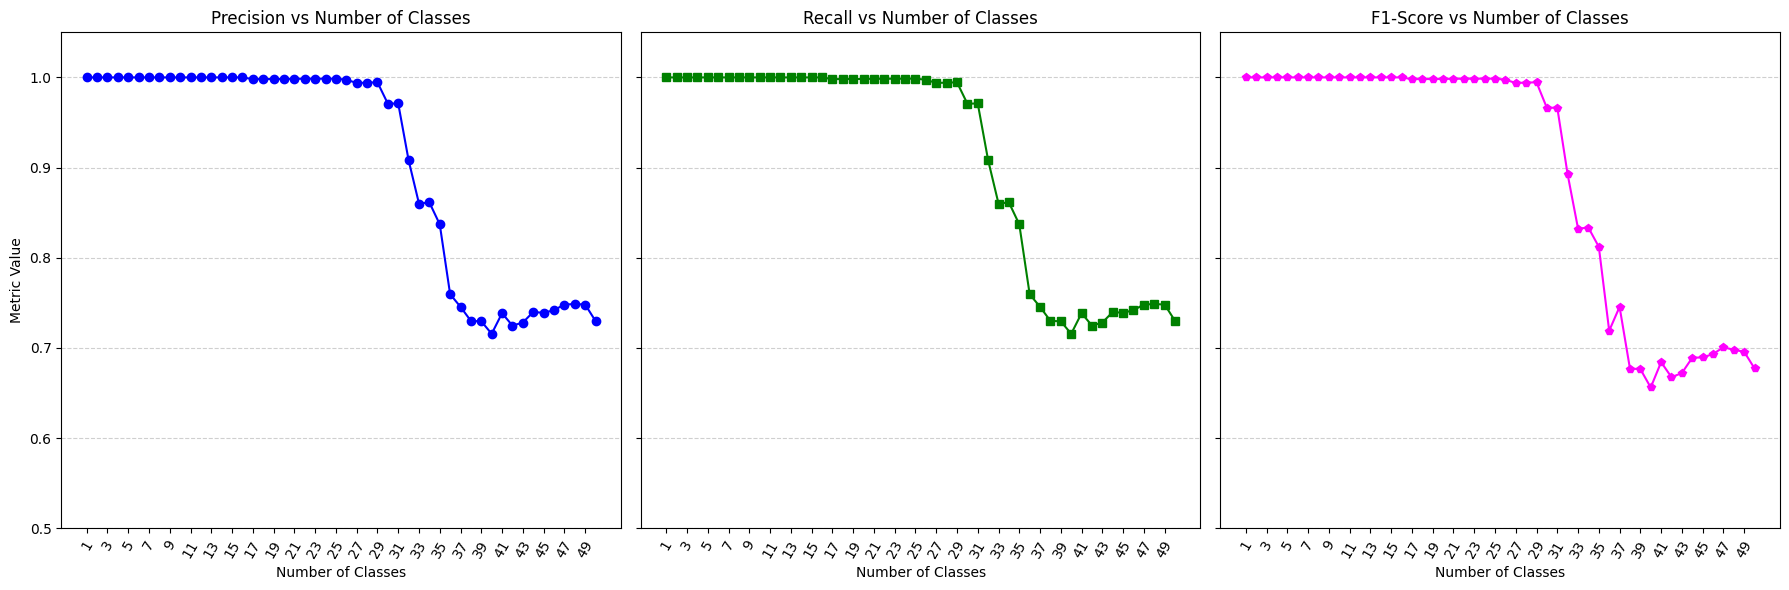

In [ ]:
import matplotlib.pyplot as plt

# === OVDJE UNOSIŠ SVOJE PODATKE ===
num = list(range(1, 51))      # Broj klasa (npr. [1, 2, 3, ..., 50])
precision = [1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.9981,0.9982,0.9982,0.9983,0.9985,0.9985,0.9986,0.9986, 0.9987, 0.9974, 0.9939, 0.9942, 0.9946, 0.9709, 0.9711, 0.9082, 0.8601, 0.8614, 0.8371, 0.7596, 0.7456, 0.7300, 0.7296, 0.7157, 0.7386, 0.7248, 0.7282, 0.7399, 0.7390, 0.7419, 0.7482, 0.7487, 0.7482, 0.7300]  # Preciznost za svaku klasu
recall = [1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.9981, 0.9982,0.9982,0.9983,0.9985,0.9985,0.9986,0.9986, 0.9987, 0.9974, 0.9939, 0.9942, 0.9946, 0.9709, 0.9711, 0.9082, 0.8601, 0.8614, 0.8371, 0.7596, 0.7456, 0.7300, 0.7296, 0.7157, 0.7386, 0.7248, 0.7282, 0.7399, 0.7390, 0.7419, 0.7482, 0.7487, 0.7482, 0.7300]     # Opoziv za svaku klasu
f1 = [1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.9981, 0.9982,0.9982,0.9983,0.9985,0.9985,0.9986,0.9986, 0.9987, 0.9974, 0.9939, 0.9942, 0.9946, 0.9662, 0.9665, 0.8924, 0.8324, 0.8334, 0.8122, 0.7191, 0.7456, 0.6771, 0.6766, 0.6562, 0.6843,0.6676 , 0.6722, 0.6892, 0.6895, 0.6933, 0.7008, 0.6980, 0.6958, 0.6773 ]         # F1 rezultat za svaku klasu

# === CRTANJE GRAFIKONA ===
plt.figure(figsize=(14, 6))

plt.plot(num, precision, marker='o', color='blue', label='Precision')
plt.plot(num, recall, marker='s', color='green', label='Recall')
plt.plot(num, f1, marker='p', color='magenta', label='F1-Score')

plt.title("Performance Metrics vs Number of Classes")
plt.xlabel("Number of Classes")
plt.ylabel("Metric Value")
plt.xticks(num, rotation=60)
plt.ylim(0.5, 1.05)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()

# === SPREMANJE U PDF (vektorski) ===
plt.savefig("numClass_scalability.pdf", format='pdf')

plt.show()

# === CRTANJE ===
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Precision
axs[0].plot(num, precision, marker='o', color='blue')
axs[0].set_title("Precision vs Number of Classes")
axs[0].set_xlabel("Number of Classes")
axs[0].set_ylabel("Metric Value")
axs[0].grid(True, axis='y', linestyle='--', alpha=0.6)
axs[0].set_ylim(0.5, 1.05)

# Recall
axs[1].plot(num, recall, marker='s', color='green')
axs[1].set_title("Recall vs Number of Classes")
axs[1].set_xlabel("Number of Classes")
axs[1].grid(True, axis='y', linestyle='--', alpha=0.6)

# F1-Score
axs[2].plot(num, f1, marker='p', color='magenta')
axs[2].set_title("F1-Score vs Number of Classes")
axs[2].set_xlabel("Number of Classes")
axs[2].grid(True, axis='y', linestyle='--', alpha=0.6)

# Podešavanje
for ax in axs:
    ax.set_xticks(num[::2])
    ax.tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.savefig("numClass_scalability_separated.pdf", format='pdf')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# === Enable LaTeX Fonts ===
import matplotlib.pyplot as plt

# Use mathtext (built-in LaTeX-like engine, no external latex needed)
plt.rcParams.update({
    "text.usetex": False,   # Disable external LaTeX
    "font.family": "serif",
    "mathtext.fontset": "cm",  # Computer Modern
    "axes.labelsize": 14,
    "font.size": 14,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})


# === DATA ===
num = list(range(1, 51))      # Broj klasa (npr. [1, 2, 3, ..., 50])
precision = [1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.9981,0.9982,0.9982,0.9983,0.9985,0.9985,0.9986,0.9986, 0.9987, 0.9974, 0.9939, 0.9942, 0.9946, 0.9709, 0.9711, 0.9082, 0.8601, 0.8614, 0.8371, 0.7596, 0.7456, 0.7300, 0.7296, 0.7157, 0.7386, 0.7248, 0.7282, 0.7399, 0.7390, 0.7419, 0.7482, 0.7487, 0.7482, 0.7300]  # Preciznost za svaku klasu
recall = [1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.9981, 0.9982,0.9982,0.9983,0.9985,0.9985,0.9986,0.9986, 0.9987, 0.9974, 0.9939, 0.9942, 0.9946, 0.9709, 0.9711, 0.9082, 0.8601, 0.8614, 0.8371, 0.7596, 0.7456, 0.7300, 0.7296, 0.7157, 0.7386, 0.7248, 0.7282, 0.7399, 0.7390, 0.7419, 0.7482, 0.7487, 0.7482, 0.7300]     # Opoziv za svaku klasu
f1 = [1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.9981, 0.9982,0.9982,0.9983,0.9985,0.9985,0.9986,0.9986, 0.9987, 0.9974, 0.9939, 0.9942, 0.9946, 0.9662, 0.9665, 0.8924, 0.8324, 0.8334, 0.8122, 0.7191, 0.7456, 0.6771, 0.6766, 0.6562, 0.6843,0.6676 , 0.6722, 0.6892, 0.6895, 0.6933, 0.7008, 0.6980, 0.6958, 0.6773 ]         # F1 rezultat za svaku klasu

# === SINGLE PLOT ===
plt.figure(figsize=(14, 6))
plt.plot(num, precision, marker='o', color='blue', label=r'Precision')
plt.plot(num, recall, marker='s', color='green', label=r'Recall')
plt.plot(num, f1, marker='p', color='magenta', label=r'F1-Score')

plt.title(r"Performance Metrics vs. Number of Classes")
plt.xlabel(r"Number of Classes")
plt.ylabel(r"Metric Value")
plt.xticks(num, rotation=60)
plt.ylim(0.5, 1.05)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.savefig("numClass_scalability.pdf", format="pdf")
plt.show()

# === SUBPLOTS ===
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

axs[0].plot(num, precision, marker='o', color='blue')
axs[0].set_title(r"Precision vs. Number of Classes")
axs[0].set_xlabel(r"Number of Classes")
axs[0].set_ylabel(r"Metric Value")
axs[0].grid(True, axis='y', linestyle='--', alpha=0.6)
axs[0].set_ylim(0.5, 1.05)

axs[1].plot(num, recall, marker='s', color='green')
axs[1].set_title(r"Recall vs. Number of Classes")
axs[1].set_xlabel(r"Number of Classes")
axs[1].grid(True, axis='y', linestyle='--', alpha=0.6)

axs[2].plot(num, f1, marker='p', color='magenta')
axs[2].set_title(r"F1-Score vs. Number of Classes")
axs[2].set_xlabel(r"Number of Classes")
axs[2].grid(True, axis='y', linestyle='--', alpha=0.6)

for ax in axs:
    ax.set_xticks(num[::2])
    ax.tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.savefig("numClass_scalability_separated.pdf", format="pdf")
plt.show()
